<a href="https://colab.research.google.com/github/WSLINMSAI/MSAI/blob/main/Copy_of_Capstone_Project_Week_4_Version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 0 — GPU & Environment Check
# If running in Colab: Runtime > Change runtime type > GPU
!nvidia-smi || echo "No NVIDIA GPU detected."

import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

Mon Nov 10 04:47:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             52W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# STEP 1 — Install & Imports
import sys, subprocess

# Install core deps (Detectron2 direct from Git for Colab robustness)
try:
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "torch", "torchvision", "torchaudio"])
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "git+https://github.com/facebookresearch/detectron2.git"])
except subprocess.CalledProcessError as e:
    print("Install error:", e)
    raise

# Imports
import os, io, json, glob, random, copy, zipfile, shutil
from pathlib import Path
import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import List, Dict
import torch

# Detectron2
from detectron2 import model_zoo
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances
from detectron2.data import (
    MetadataCatalog, DatasetCatalog,
    build_detection_test_loader, build_detection_train_loader
)
from detectron2.data import detection_utils as utils, transforms as T
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()
print("✅ Detectron2 ready.")


✅ Detectron2 ready.


In [ ]:
# STEP 2 — Upload & Unzip Your Data
from google.colab import files

print("Upload your dataset ZIP (contains VIA annotations and images).")
uploaded = files.upload()   # pick your .zip
zip_name = next(iter(uploaded))

!mkdir -p /content/dental_raw
!unzip -q "$zip_name" -d /content/dental_raw
print("Unzipped to /content/dental_raw")

Upload your dataset ZIP (contains VIA annotations and images).


Saving panoramic_dental_xray.zip to panoramic_dental_xray.zip
Unzipped to /content/dental_raw


In [ ]:
# STEP 3 — Convert VIA 2.x JSON to COCO
JSON_PATH = '/content/dental_raw/annotations.json'   # <-- change if needed
IMG_SEARCH_ROOT = '/content/dental_raw'

assert os.path.exists(JSON_PATH), f"Missing {JSON_PATH}"
with open(JSON_PATH, 'r') as f:
    via = json.load(f)

if '_via_img_metadata' not in via:
    raise SystemExit('This JSON is not VIA 2.x (_via_img_metadata missing).')

via_items = list(via['_via_img_metadata'].values())

def find_img(basename):
    hits = glob.glob(os.path.join(IMG_SEARCH_ROOT, '**', basename), recursive=True)
    return hits[0] if hits else None

def via_shape_to_coco_seg(shape):
    xs = shape['all_points_x']; ys = shape['all_points_y']
    pts = list(zip(xs, ys))
    if shape.get('name') == 'polyline' and pts and pts[0] != pts[-1]:
        pts.append(pts[0])  # close polyline
    seg = [v for (x,y) in pts for v in (float(x), float(y))]
    return [seg]

def coco_bbox_from_points(xs, ys):
    x0, y0 = float(min(xs)), float(min(ys))
    w, h = float(max(xs)-x0), float(max(ys)-y0)
    return [x0, y0, w, h]

def poly_area(xs, ys):
    area = 0.0
    n = len(xs)
    for i in range(n):
        j = (i+1) % n
        area += xs[i]*ys[j] - xs[j]*ys[i]
    return abs(area)/2.0

images, annotations = [], []
cat = {'id': 1, 'name': 'tooth', 'supercategory': 'tooth'}
ann_id = 1
img_id = 1
fname_to_path = {}
skipped = 0

for item in via_items:
    fn = item.get('filename')
    if not fn:
        continue
    ipath = find_img(os.path.basename(fn))
    if not ipath:
        print('WARN: missing image', fn); skipped += 1; continue
    img = cv2.imread(ipath)
    if img is None:
        print('WARN: unreadable', ipath); skipped += 1; continue

    h, w = img.shape[:2]
    images.append({'id': img_id, 'file_name': os.path.basename(fn), 'width': w, 'height': h})
    fname_to_path[os.path.basename(fn)] = ipath

    for r in item.get('regions', []):
        sa = r.get('shape_attributes', {}); name = sa.get('name', '')
        if name not in ('polyline', 'polygon'):
            continue
        xs = list(sa.get('all_points_x', []) or []); ys = list(sa.get('all_points_y', []) or [])
        if len(xs) < 3 or len(xs) != len(ys):
            continue
        if name == 'polyline' and (xs[0] != xs[-1] or ys[0] != ys[-1]):
            xs_closed = xs + [xs[0]]; ys_closed = ys + [ys[0]]
        else:
            xs_closed, ys_closed = xs, ys

        seg = via_shape_to_coco_seg(sa)
        bbox = coco_bbox_from_points(xs_closed, ys_closed)
        area = float(poly_area(xs_closed, ys_closed))
        annotations.append({
            'id': ann_id, 'image_id': img_id, 'category_id': 1, 'iscrowd': 0,
            'bbox': bbox, 'area': area, 'segmentation': seg
        })
        ann_id += 1

    img_id += 1

print(f"Built COCO: {len(images)} images, {len(annotations)} anns, skipped {skipped}")

# 80/20 split
random.seed(42)
img_ids = [im['id'] for im in images]
random.shuffle(img_ids)
cut = int(0.8 * len(img_ids))
train_ids, val_ids = set(img_ids[:cut]), set(img_ids[cut:])

def subset(ids_set):
    ims = [im for im in images if im['id'] in ids_set]
    ann_map = {i: [] for i in ids_set}
    for a in annotations:
        if a['image_id'] in ids_set:
            ann_map[a['image_id']].append(a)
    new_anns, new_id = [], 1
    for k in ann_map:
        for a in ann_map[k]:
            b = dict(a); b['id'] = new_id; new_id += 1
            new_anns.append(b)
    return {'info': {}, 'images': ims, 'annotations': new_anns, 'categories': [cat]}

os.makedirs('/content/dental/annotations', exist_ok=True)
os.makedirs('/content/dental/train', exist_ok=True)
os.makedirs('/content/dental/val', exist_ok=True)

with open('/content/dental/annotations/instances_train.json', 'w') as f:
    json.dump(subset(train_ids), f)
with open('/content/dental/annotations/instances_val.json', 'w') as f:
    json.dump(subset(val_ids), f)

# copy images into clean folders
def link_or_copy(ids_set, out_dir):
    for im in [im for im in images if im['id'] in ids_set]:
        fn = im['file_name']; src = fname_to_path.get(fn)
        if not src or not os.path.exists(src):
            continue
        dst = os.path.join(out_dir, fn)
        if os.path.exists(dst):
            continue
        try:
            os.symlink(src, dst)
        except Exception:
            shutil.copy2(src, dst)

link_or_copy(train_ids, '/content/dental/train')
link_or_copy(val_ids, '/content/dental/val')

print('✅ Step 3 complete: COCO JSONs & image folders ready.')

Built COCO: 107 images, 771 anns, skipped 0
✅ Step 3 complete: COCO JSONs & image folders ready.


Classes: ['tooth']
Showing up to 3 random training samples...
[11/10 04:58:55 d2.data.datasets.coco]: Loaded 85 images in COCO format from /content/dental/annotations/instances_train.json


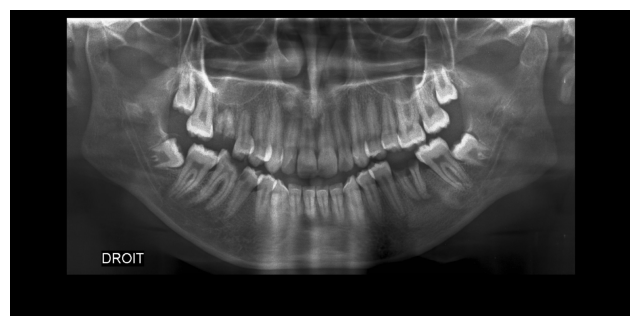

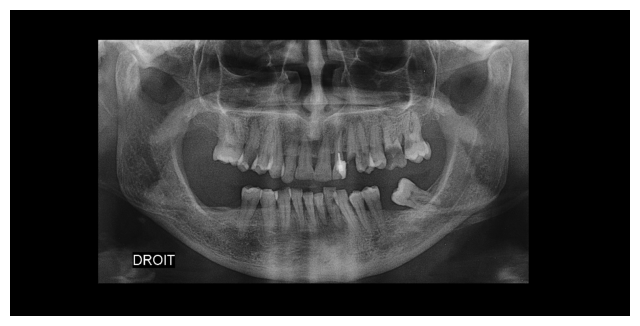

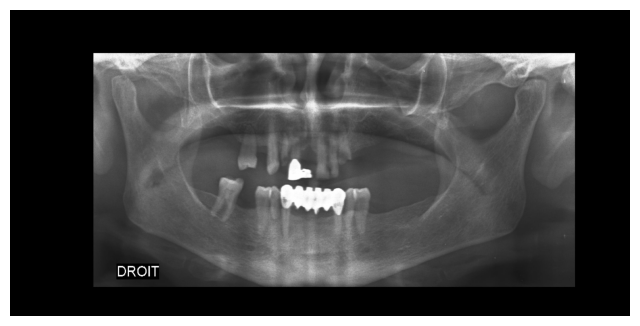

✅ Step 4 complete.


In [ ]:
# STEP 4 — Register Datasets + Visual Check
TRAIN_DIR = '/content/dental/train'
VAL_DIR   = '/content/dental/val'
TRAIN_JSON = '/content/dental/annotations/instances_train.json'
VAL_JSON   = '/content/dental/annotations/instances_val.json'

with open(TRAIN_JSON) as f:
    cls_names = [c['name'] for c in json.load(f)['categories']]
print('Classes:', cls_names)

register_coco_instances('dental_train', {}, TRAIN_JSON, TRAIN_DIR)
register_coco_instances('dental_val',   {}, VAL_JSON,   VAL_DIR)
MetadataCatalog.get('dental_train').thing_classes = cls_names
MetadataCatalog.get('dental_val').thing_classes   = cls_names

# Visualize a few training samples
from detectron2.utils.visualizer import Visualizer
print('Showing up to 3 random training samples...')
ds = DatasetCatalog.get('dental_train')
for d in random.sample(ds, min(3, len(ds))):
    img = cv2.cvtColor(cv2.imread(d['file_name']), cv2.COLOR_BGR2RGB)
    vis = Visualizer(img, metadata=MetadataCatalog.get('dental_train'), scale=0.7).draw_dataset_dict(d)
    plt.figure(figsize=(8,6)); plt.axis('off'); plt.imshow(vis.get_image()); plt.show()

print('✅ Step 4 complete.')

In [ ]:
# STEP 5I — Improved Config + Strong Augs (compat) + Trainer (R101)
# (Includes crop + blur compatibility fixes)

from pathlib import Path
import os, copy, torch

from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import (
    build_detection_train_loader, build_detection_test_loader,
    DatasetCatalog, MetadataCatalog, detection_utils as utils
)
from detectron2.data import transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

def get_base_cfg(out_dir: str, pretrained: bool, max_iter: int):
    cfg = get_cfg()
    # R50 -> R101 backbone
    cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'))
    cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.SOLVER.AMP.ENABLED = True

    cfg.DATASETS.TRAIN = ('dental_train',)
    cfg.DATASETS.TEST  = ('dental_val',)
    cfg.DATALOADER.NUM_WORKERS = 2

    cfg.SOLVER.IMS_PER_BATCH = 1
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = max_iter
    cfg.SOLVER.STEPS = []
    cfg.SOLVER.WARMUP_ITERS = 0

    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get('dental_train').thing_classes)

    # R50 -> R101 weights
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml') if pretrained else ''

    cfg.OUTPUT_DIR = out_dir
    cfg.TEST.EVAL_PERIOD = max(200, max_iter//3)
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    return cfg

# Strong augmentations (compatible with older/newer Detectron2 builds)
# - Uses RandomCrop (not CategoryAreaConstraint)
# - Removes GaussianBlur (not available in some builds)
def mapper_strong_aug(dataset_dict):
    dd = copy.deepcopy(dataset_dict)
    image = utils.read_image(dd['file_name'], format='BGR')
    augs = T.AugmentationList([
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        T.RandomBrightness(0.7, 1.3),
        T.RandomContrast(0.7, 1.3),
        T.RandomSaturation(0.7, 1.3),
        T.RandomRotation(angle=[-10, 10]),
        T.RandomExtent(scale_range=(0.9, 1.1), shift_range=(0.05, 0.05)),
        T.RandomCrop(crop_type="relative", crop_size=(0.8, 0.8)),
        T.ResizeShortestEdge(short_edge_length=(512, 640, 768), max_size=1333, sample_style="choice"),
    ])
    aug_input = T.AugInput(image)
    transforms = augs(aug_input)
    image = aug_input.image

    dd['image'] = torch.as_tensor(image.transpose(2,0,1).astype('float32'))
    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dd.pop('annotations') if obj.get('iscrowd', 0) == 0
    ]
    dd['instances'] = utils.annotations_to_instances(annos, image.shape[:2])
    return dd

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        # Use the strong, compatibility-safe mapper
        return build_detection_train_loader(cfg, mapper=mapper_strong_aug)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, 'inference')
        return COCOEvaluator(dataset_name, output_dir=output_folder)

def train_and_eval(out_dir: Path, pretrained: bool, max_iter: int):
    cfg = get_base_cfg(str(out_dir), pretrained, max_iter)
    trainer = CustomTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

    # Evaluate
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    predictor = DefaultPredictor(cfg)
    evaluator = COCOEvaluator('dental_val', output_dir=os.path.join(cfg.OUTPUT_DIR, 'inference'))
    val_loader = build_detection_test_loader(cfg, 'dental_val')
    results = inference_on_dataset(predictor.model, val_loader, evaluator)

    # Save cfg for record
    with open(os.path.join(cfg.OUTPUT_DIR, 'config.yaml'), 'w') as f:
        f.write(cfg.dump())
    return cfg, results

def ap50_of(results_dict, kind='segm'):
    return float(results_dict.get(kind, {}).get('AP50', 0.0))

print('✅ STEP 5I ready (R101 + strong augs with compatibility fixes).')


✅ STEP 5I ready (R101 + strong augs with compatibility fixes).


In [ ]:
# STEP 6I — Train Improved Model (no baseline)
BASE_OUT = Path('/content/capstone_runs')
RUN_NAME = 'improved_R101_strong'
ITER_I   = 4000  # Increase iteration count

cfgI, resI = train_and_eval(BASE_OUT / RUN_NAME, pretrained=True, max_iter=ITER_I)

print("\n========== IMPROVED MODEL ==========")
segm_ap50 = ap50_of(resI, 'segm'); bbox_ap50 = ap50_of(resI, 'bbox')
print(f"Segmentation AP50: {segm_ap50:.4f}")
print(f"BBox         AP50: {bbox_ap50:.4f}")
print("====================================")

# Paths used by later steps
BEST_WEIGHTS_PATH = f'/content/capstone_runs/{RUN_NAME}/model_final.pth'
DET_JSON          = f'/content/capstone_runs/{RUN_NAME}/inference/coco_instances_results.json'
print('BEST_WEIGHTS_PATH =', BEST_WEIGHTS_PATH)
print('DET_JSON          =', DET_JSON)


[11/10 04:59:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()
model_final_a3ec72.pkl: 254MB [00:00, 293MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[11/10 04:59:07 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-a

[11/10 04:59:19 d2.utils.events]:  eta: 0:22:01  iter: 19  total_loss: 2.38  loss_cls: 0.5868  loss_box_reg: 0.7874  loss_mask: 0.6838  loss_rpn_cls: 0.1529  loss_rpn_loc: 0.1966    time: 0.3905  last_time: 0.5607  data_time: 0.1859  last_data_time: 0.4624   lr: 0.00025  max_mem: 1615M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 04:59:33 d2.utils.events]:  eta: 0:21:54  iter: 39  total_loss: 2.044  loss_cls: 0.4514  loss_box_reg: 0.7908  loss_mask: 0.5955  loss_rpn_cls: 0.08235  loss_rpn_loc: 0.1626    time: 0.3898  last_time: 0.5275  data_time: 0.2493  last_data_time: 0.2138   lr: 0.00025  max_mem: 1615M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 04:59:42 d2.utils.events]:  eta: 0:25:23  iter: 59  total_loss: 1.828  loss_cls: 0.3835  loss_box_reg: 0.7529  loss_mask: 0.4621  loss_rpn_cls: 0.06242  loss_rpn_loc: 0.144    time: 0.4113  last_time: 0.4254  data_time: 0.3219  last_data_time: 0.1064   lr: 0.00025  max_mem: 1615M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 04:59:51 d2.utils.events]:  eta: 0:25:15  iter: 79  total_loss: 1.564  loss_cls: 0.3302  loss_box_reg: 0.6956  loss_mask: 0.3529  loss_rpn_cls: 0.04009  loss_rpn_loc: 0.1521    time: 0.4189  last_time: 0.1586  data_time: 0.3417  last_data_time: 0.0594   lr: 0.00025  max_mem: 1615M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:00:00 d2.utils.events]:  eta: 0:25:08  iter: 99  total_loss: 1.484  loss_cls: 0.2883  loss_box_reg: 0.6716  loss_mask: 0.331  loss_rpn_cls: 0.02697  loss_rpn_loc: 0.1285    time: 0.4289  last_time: 0.2827  data_time: 0.3682  last_data_time: 0.1849   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:00:09 d2.utils.events]:  eta: 0:27:34  iter: 119  total_loss: 1.322  loss_cls: 0.2877  loss_box_reg: 0.5623  loss_mask: 0.3092  loss_rpn_cls: 0.02095  loss_rpn_loc: 0.1233    time: 0.4348  last_time: 0.5443  data_time: 0.3655  last_data_time: 0.4460   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:00:19 d2.utils.events]:  eta: 0:27:31  iter: 139  total_loss: 1.313  loss_cls: 0.2725  loss_box_reg: 0.5473  loss_mask: 0.3138  loss_rpn_cls: 0.01262  loss_rpn_loc: 0.1282    time: 0.4399  last_time: 0.8497  data_time: 0.3691  last_data_time: 0.7519   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:00:27 d2.utils.events]:  eta: 0:27:29  iter: 159  total_loss: 1.175  loss_cls: 0.28  loss_box_reg: 0.4812  loss_mask: 0.2999  loss_rpn_cls: 0.01677  loss_rpn_loc: 0.1217    time: 0.4402  last_time: 0.4267  data_time: 0.3429  last_data_time: 0.3257   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:00:37 d2.utils.events]:  eta: 0:27:44  iter: 179  total_loss: 1.181  loss_cls: 0.2396  loss_box_reg: 0.4918  loss_mask: 0.2852  loss_rpn_cls: 0.009203  loss_rpn_loc: 0.1249    time: 0.4416  last_time: 0.1868  data_time: 0.3546  last_data_time: 0.0879   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:00:46 d2.utils.events]:  eta: 0:27:40  iter: 199  total_loss: 1.105  loss_cls: 0.2366  loss_box_reg: 0.4328  loss_mask: 0.2682  loss_rpn_cls: 0.01083  loss_rpn_loc: 0.1196    time: 0.4431  last_time: 0.2139  data_time: 0.3576  last_data_time: 0.1169   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:00:55 d2.utils.events]:  eta: 0:27:47  iter: 219  total_loss: 1.046  loss_cls: 0.2334  loss_box_reg: 0.4336  loss_mask: 0.2786  loss_rpn_cls: 0.00926  loss_rpn_loc: 0.1283    time: 0.4441  last_time: 0.3412  data_time: 0.3454  last_data_time: 0.2453   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:01:04 d2.utils.events]:  eta: 0:27:39  iter: 239  total_loss: 1.119  loss_cls: 0.2534  loss_box_reg: 0.4561  loss_mask: 0.2743  loss_rpn_cls: 0.006807  loss_rpn_loc: 0.1188    time: 0.4454  last_time: 0.7825  data_time: 0.3605  last_data_time: 0.6842   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:01:13 d2.utils.events]:  eta: 0:27:30  iter: 259  total_loss: 1.056  loss_cls: 0.2356  loss_box_reg: 0.4375  loss_mask: 0.2638  loss_rpn_cls: 0.008978  loss_rpn_loc: 0.1128    time: 0.4470  last_time: 0.7928  data_time: 0.3663  last_data_time: 0.6951   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:01:23 d2.utils.events]:  eta: 0:27:21  iter: 279  total_loss: 1.047  loss_cls: 0.2294  loss_box_reg: 0.4435  loss_mask: 0.2609  loss_rpn_cls: 0.006651  loss_rpn_loc: 0.1168    time: 0.4482  last_time: 0.8454  data_time: 0.3654  last_data_time: 0.7481   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:01:32 d2.utils.events]:  eta: 0:27:12  iter: 299  total_loss: 1.152  loss_cls: 0.2706  loss_box_reg: 0.4654  loss_mask: 0.2684  loss_rpn_cls: 0.009436  loss_rpn_loc: 0.1255    time: 0.4488  last_time: 0.7659  data_time: 0.3575  last_data_time: 0.6698   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:01:41 d2.utils.events]:  eta: 0:27:03  iter: 319  total_loss: 1.056  loss_cls: 0.2262  loss_box_reg: 0.4175  loss_mask: 0.2483  loss_rpn_cls: 0.004315  loss_rpn_loc: 0.1141    time: 0.4497  last_time: 0.7919  data_time: 0.3629  last_data_time: 0.6932   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:01:50 d2.utils.events]:  eta: 0:26:54  iter: 339  total_loss: 0.9407  loss_cls: 0.2246  loss_box_reg: 0.3755  loss_mask: 0.2562  loss_rpn_cls: 0.007728  loss_rpn_loc: 0.1104    time: 0.4503  last_time: 0.8770  data_time: 0.3596  last_data_time: 0.7784   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:01:59 d2.utils.events]:  eta: 0:26:46  iter: 359  total_loss: 0.9571  loss_cls: 0.1977  loss_box_reg: 0.4062  loss_mask: 0.2631  loss_rpn_cls: 0.006326  loss_rpn_loc: 0.1128    time: 0.4504  last_time: 0.7167  data_time: 0.3521  last_data_time: 0.6174   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:02:08 d2.utils.events]:  eta: 0:26:42  iter: 379  total_loss: 1.03  loss_cls: 0.2185  loss_box_reg: 0.4283  loss_mask: 0.2587  loss_rpn_cls: 0.006199  loss_rpn_loc: 0.1274    time: 0.4505  last_time: 0.5121  data_time: 0.3534  last_data_time: 0.4126   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:02:17 d2.utils.events]:  eta: 0:26:33  iter: 399  total_loss: 0.9731  loss_cls: 0.2033  loss_box_reg: 0.3812  loss_mask: 0.2676  loss_rpn_cls: 0.006355  loss_rpn_loc: 0.09977    time: 0.4508  last_time: 0.6757  data_time: 0.3551  last_data_time: 0.5800   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:02:26 d2.utils.events]:  eta: 0:26:25  iter: 419  total_loss: 0.91  loss_cls: 0.2056  loss_box_reg: 0.3755  loss_mask: 0.2399  loss_rpn_cls: 0.004118  loss_rpn_loc: 0.0984    time: 0.4503  last_time: 0.1400  data_time: 0.3409  last_data_time: 0.0351   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:02:35 d2.utils.events]:  eta: 0:26:16  iter: 439  total_loss: 0.9108  loss_cls: 0.2089  loss_box_reg: 0.344  loss_mask: 0.2463  loss_rpn_cls: 0.003605  loss_rpn_loc: 0.09447    time: 0.4507  last_time: 0.1742  data_time: 0.3590  last_data_time: 0.0715   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:02:45 d2.utils.events]:  eta: 0:26:07  iter: 459  total_loss: 0.9682  loss_cls: 0.2195  loss_box_reg: 0.3885  loss_mask: 0.2545  loss_rpn_cls: 0.004866  loss_rpn_loc: 0.1058    time: 0.4509  last_time: 0.1017  data_time: 0.3541  last_data_time: 0.0034   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:02:54 d2.utils.events]:  eta: 0:25:58  iter: 479  total_loss: 0.8629  loss_cls: 0.1748  loss_box_reg: 0.3636  loss_mask: 0.2254  loss_rpn_cls: 0.003919  loss_rpn_loc: 0.1028    time: 0.4511  last_time: 0.1253  data_time: 0.3561  last_data_time: 0.0239   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:03:03 d2.utils.events]:  eta: 0:25:49  iter: 499  total_loss: 1.007  loss_cls: 0.2146  loss_box_reg: 0.3838  loss_mask: 0.2668  loss_rpn_cls: 0.006642  loss_rpn_loc: 0.1084    time: 0.4514  last_time: 0.2236  data_time: 0.3602  last_data_time: 0.1182   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:03:12 d2.utils.events]:  eta: 0:25:40  iter: 519  total_loss: 0.9089  loss_cls: 0.1779  loss_box_reg: 0.3479  loss_mask: 0.2451  loss_rpn_cls: 0.003428  loss_rpn_loc: 0.09688    time: 0.4515  last_time: 0.1196  data_time: 0.3560  last_data_time: 0.0181   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:03:21 d2.utils.events]:  eta: 0:25:31  iter: 539  total_loss: 0.9219  loss_cls: 0.1873  loss_box_reg: 0.3849  loss_mask: 0.2471  loss_rpn_cls: 0.004556  loss_rpn_loc: 0.1005    time: 0.4517  last_time: 0.1026  data_time: 0.3540  last_data_time: 0.0014   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:03:30 d2.utils.events]:  eta: 0:25:23  iter: 559  total_loss: 0.8555  loss_cls: 0.1917  loss_box_reg: 0.3569  loss_mask: 0.246  loss_rpn_cls: 0.006088  loss_rpn_loc: 0.0958    time: 0.4514  last_time: 0.1045  data_time: 0.3397  last_data_time: 0.0034   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:03:39 d2.utils.events]:  eta: 0:25:14  iter: 579  total_loss: 0.9365  loss_cls: 0.2003  loss_box_reg: 0.3955  loss_mask: 0.25  loss_rpn_cls: 0.002394  loss_rpn_loc: 0.1076    time: 0.4519  last_time: 0.1033  data_time: 0.3662  last_data_time: 0.0017   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:03:48 d2.utils.events]:  eta: 0:25:05  iter: 599  total_loss: 0.9  loss_cls: 0.1947  loss_box_reg: 0.3555  loss_mask: 0.254  loss_rpn_cls: 0.005143  loss_rpn_loc: 0.09984    time: 0.4519  last_time: 0.1022  data_time: 0.3525  last_data_time: 0.0020   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:03:58 d2.utils.events]:  eta: 0:24:56  iter: 619  total_loss: 0.9379  loss_cls: 0.1785  loss_box_reg: 0.3771  loss_mask: 0.2485  loss_rpn_cls: 0.003994  loss_rpn_loc: 0.103    time: 0.4522  last_time: 0.0984  data_time: 0.3623  last_data_time: 0.0012   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:04:07 d2.utils.events]:  eta: 0:24:47  iter: 639  total_loss: 0.9118  loss_cls: 0.2179  loss_box_reg: 0.381  loss_mask: 0.2328  loss_rpn_cls: 0.003374  loss_rpn_loc: 0.1063    time: 0.4522  last_time: 0.0994  data_time: 0.3518  last_data_time: 0.0011   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:04:16 d2.utils.events]:  eta: 0:24:38  iter: 659  total_loss: 0.9412  loss_cls: 0.2289  loss_box_reg: 0.3725  loss_mask: 0.2258  loss_rpn_cls: 0.002797  loss_rpn_loc: 0.1029    time: 0.4526  last_time: 0.1031  data_time: 0.3664  last_data_time: 0.0023   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:04:25 d2.utils.events]:  eta: 0:24:29  iter: 679  total_loss: 0.8828  loss_cls: 0.1893  loss_box_reg: 0.3432  loss_mask: 0.235  loss_rpn_cls: 0.001894  loss_rpn_loc: 0.09517    time: 0.4523  last_time: 0.0998  data_time: 0.3426  last_data_time: 0.0011   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:04:34 d2.utils.events]:  eta: 0:24:21  iter: 699  total_loss: 0.8488  loss_cls: 0.185  loss_box_reg: 0.3448  loss_mask: 0.2305  loss_rpn_cls: 0.002193  loss_rpn_loc: 0.08982    time: 0.4525  last_time: 0.1932  data_time: 0.3615  last_data_time: 0.0884   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:04:43 d2.utils.events]:  eta: 0:24:12  iter: 719  total_loss: 0.958  loss_cls: 0.2084  loss_box_reg: 0.3992  loss_mask: 0.2555  loss_rpn_cls: 0.003826  loss_rpn_loc: 0.1046    time: 0.4527  last_time: 0.1048  data_time: 0.3623  last_data_time: 0.0025   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:04:53 d2.utils.events]:  eta: 0:24:03  iter: 739  total_loss: 0.8949  loss_cls: 0.1853  loss_box_reg: 0.3456  loss_mask: 0.243  loss_rpn_cls: 0.001561  loss_rpn_loc: 0.1004    time: 0.4530  last_time: 0.1054  data_time: 0.3619  last_data_time: 0.0023   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:05:02 d2.utils.events]:  eta: 0:23:54  iter: 759  total_loss: 0.9261  loss_cls: 0.1793  loss_box_reg: 0.3528  loss_mask: 0.2586  loss_rpn_cls: 0.002418  loss_rpn_loc: 0.09519    time: 0.4531  last_time: 0.0987  data_time: 0.3600  last_data_time: 0.0020   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:05:11 d2.utils.events]:  eta: 0:23:45  iter: 779  total_loss: 0.9464  loss_cls: 0.2089  loss_box_reg: 0.3742  loss_mask: 0.2497  loss_rpn_cls: 0.005477  loss_rpn_loc: 0.1037    time: 0.4531  last_time: 0.1013  data_time: 0.3543  last_data_time: 0.0012   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:05:20 d2.utils.events]:  eta: 0:23:36  iter: 799  total_loss: 0.9639  loss_cls: 0.1965  loss_box_reg: 0.3733  loss_mask: 0.254  loss_rpn_cls: 0.003915  loss_rpn_loc: 0.107    time: 0.4532  last_time: 0.1110  data_time: 0.3544  last_data_time: 0.0011   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:05:29 d2.utils.events]:  eta: 0:23:27  iter: 819  total_loss: 0.8698  loss_cls: 0.1814  loss_box_reg: 0.3461  loss_mask: 0.236  loss_rpn_cls: 0.002862  loss_rpn_loc: 0.09824    time: 0.4530  last_time: 0.1038  data_time: 0.3463  last_data_time: 0.0022   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:05:38 d2.utils.events]:  eta: 0:23:19  iter: 839  total_loss: 0.9283  loss_cls: 0.1678  loss_box_reg: 0.3773  loss_mask: 0.245  loss_rpn_cls: 0.002209  loss_rpn_loc: 0.09771    time: 0.4534  last_time: 0.1051  data_time: 0.3675  last_data_time: 0.0023   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:05:47 d2.utils.events]:  eta: 0:23:10  iter: 859  total_loss: 0.8755  loss_cls: 0.1826  loss_box_reg: 0.3632  loss_mask: 0.2277  loss_rpn_cls: 0.002134  loss_rpn_loc: 0.09929    time: 0.4532  last_time: 0.0994  data_time: 0.3479  last_data_time: 0.0014   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:05:56 d2.utils.events]:  eta: 0:23:01  iter: 879  total_loss: 0.8748  loss_cls: 0.1821  loss_box_reg: 0.3402  loss_mask: 0.2257  loss_rpn_cls: 0.00328  loss_rpn_loc: 0.09347    time: 0.4530  last_time: 0.1019  data_time: 0.3452  last_data_time: 0.0024   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:06:05 d2.utils.events]:  eta: 0:22:52  iter: 899  total_loss: 0.9161  loss_cls: 0.1837  loss_box_reg: 0.3727  loss_mask: 0.24  loss_rpn_cls: 0.0055  loss_rpn_loc: 0.09478    time: 0.4532  last_time: 0.1007  data_time: 0.3611  last_data_time: 0.0026   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:06:14 d2.utils.events]:  eta: 0:22:43  iter: 919  total_loss: 0.8346  loss_cls: 0.1735  loss_box_reg: 0.3236  loss_mask: 0.2547  loss_rpn_cls: 0.001815  loss_rpn_loc: 0.08649    time: 0.4532  last_time: 0.0980  data_time: 0.3562  last_data_time: 0.0025   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:06:24 d2.utils.events]:  eta: 0:22:34  iter: 939  total_loss: 0.83  loss_cls: 0.1612  loss_box_reg: 0.3391  loss_mask: 0.2314  loss_rpn_cls: 0.003162  loss_rpn_loc: 0.09629    time: 0.4535  last_time: 0.0980  data_time: 0.3663  last_data_time: 0.0023   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:06:33 d2.utils.events]:  eta: 0:22:25  iter: 959  total_loss: 0.8741  loss_cls: 0.1788  loss_box_reg: 0.3379  loss_mask: 0.2311  loss_rpn_cls: 0.001543  loss_rpn_loc: 0.0893    time: 0.4535  last_time: 0.0980  data_time: 0.3551  last_data_time: 0.0015   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:06:42 d2.utils.events]:  eta: 0:22:17  iter: 979  total_loss: 0.8348  loss_cls: 0.1939  loss_box_reg: 0.3288  loss_mask: 0.2288  loss_rpn_cls: 0.001655  loss_rpn_loc: 0.09014    time: 0.4534  last_time: 0.1016  data_time: 0.3535  last_data_time: 0.0014   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:06:51 d2.utils.events]:  eta: 0:22:08  iter: 999  total_loss: 0.8136  loss_cls: 0.1676  loss_box_reg: 0.353  loss_mask: 0.2212  loss_rpn_cls: 0.002225  loss_rpn_loc: 0.1053    time: 0.4536  last_time: 0.1029  data_time: 0.3607  last_data_time: 0.0021   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:07:00 d2.utils.events]:  eta: 0:22:13  iter: 1019  total_loss: 0.8906  loss_cls: 0.1754  loss_box_reg: 0.3518  loss_mask: 0.2436  loss_rpn_cls: 0.001543  loss_rpn_loc: 0.09872    time: 0.4538  last_time: 0.1016  data_time: 0.3683  last_data_time: 0.0022   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:07:10 d2.utils.events]:  eta: 0:22:17  iter: 1039  total_loss: 0.811  loss_cls: 0.1729  loss_box_reg: 0.3116  loss_mask: 0.2005  loss_rpn_cls: 0.001739  loss_rpn_loc: 0.09499    time: 0.4540  last_time: 0.0978  data_time: 0.3527  last_data_time: 0.0013   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:07:19 d2.utils.events]:  eta: 0:22:11  iter: 1059  total_loss: 0.8732  loss_cls: 0.1726  loss_box_reg: 0.3532  loss_mask: 0.2404  loss_rpn_cls: 0.002678  loss_rpn_loc: 0.0889    time: 0.4541  last_time: 0.0996  data_time: 0.3622  last_data_time: 0.0012   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:07:28 d2.utils.events]:  eta: 0:22:13  iter: 1079  total_loss: 0.9171  loss_cls: 0.1882  loss_box_reg: 0.3676  loss_mask: 0.2436  loss_rpn_cls: 0.002935  loss_rpn_loc: 0.09739    time: 0.4543  last_time: 0.1007  data_time: 0.3626  last_data_time: 0.0012   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:07:37 d2.utils.events]:  eta: 0:22:04  iter: 1099  total_loss: 0.8613  loss_cls: 0.1766  loss_box_reg: 0.3105  loss_mask: 0.2395  loss_rpn_cls: 0.001095  loss_rpn_loc: 0.09899    time: 0.4542  last_time: 0.1002  data_time: 0.3500  last_data_time: 0.0012   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:07:46 d2.utils.events]:  eta: 0:21:41  iter: 1119  total_loss: 0.8483  loss_cls: 0.1638  loss_box_reg: 0.3459  loss_mask: 0.2382  loss_rpn_cls: 0.002557  loss_rpn_loc: 0.09275    time: 0.4542  last_time: 0.1000  data_time: 0.3562  last_data_time: 0.0020   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:07:55 d2.utils.events]:  eta: 0:21:32  iter: 1139  total_loss: 0.8521  loss_cls: 0.1571  loss_box_reg: 0.3476  loss_mask: 0.2357  loss_rpn_cls: 0.001373  loss_rpn_loc: 0.09164    time: 0.4543  last_time: 0.1038  data_time: 0.3601  last_data_time: 0.0023   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:08:05 d2.utils.events]:  eta: 0:21:23  iter: 1159  total_loss: 0.9063  loss_cls: 0.1897  loss_box_reg: 0.3681  loss_mask: 0.2471  loss_rpn_cls: 0.001952  loss_rpn_loc: 0.09947    time: 0.4546  last_time: 0.1017  data_time: 0.3706  last_data_time: 0.0011   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:08:14 d2.utils.events]:  eta: 0:21:27  iter: 1179  total_loss: 0.9039  loss_cls: 0.1799  loss_box_reg: 0.3502  loss_mask: 0.2339  loss_rpn_cls: 0.00267  loss_rpn_loc: 0.1017    time: 0.4548  last_time: 0.1046  data_time: 0.3661  last_data_time: 0.0026   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:08:23 d2.utils.events]:  eta: 0:21:34  iter: 1199  total_loss: 0.8324  loss_cls: 0.1577  loss_box_reg: 0.3324  loss_mask: 0.239  loss_rpn_cls: 0.001684  loss_rpn_loc: 0.08568    time: 0.4549  last_time: 0.1011  data_time: 0.3599  last_data_time: 0.0024   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:08:32 d2.utils.events]:  eta: 0:21:30  iter: 1219  total_loss: 0.8424  loss_cls: 0.1929  loss_box_reg: 0.3514  loss_mask: 0.2343  loss_rpn_cls: 0.002256  loss_rpn_loc: 0.0976    time: 0.4548  last_time: 0.1029  data_time: 0.3505  last_data_time: 0.0020   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:08:41 d2.utils.events]:  eta: 0:21:21  iter: 1239  total_loss: 0.869  loss_cls: 0.1734  loss_box_reg: 0.3222  loss_mask: 0.2357  loss_rpn_cls: 0.001907  loss_rpn_loc: 0.08549    time: 0.4547  last_time: 0.1001  data_time: 0.3523  last_data_time: 0.0026   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:08:51 d2.utils.events]:  eta: 0:21:12  iter: 1259  total_loss: 0.8512  loss_cls: 0.1643  loss_box_reg: 0.3426  loss_mask: 0.2441  loss_rpn_cls: 0.00216  loss_rpn_loc: 0.08685    time: 0.4549  last_time: 0.1020  data_time: 0.3682  last_data_time: 0.0017   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:09:00 d2.utils.events]:  eta: 0:21:02  iter: 1279  total_loss: 0.8877  loss_cls: 0.1745  loss_box_reg: 0.3563  loss_mask: 0.2486  loss_rpn_cls: 0.002044  loss_rpn_loc: 0.09845    time: 0.4549  last_time: 0.0988  data_time: 0.3534  last_data_time: 0.0012   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:09:09 d2.utils.events]:  eta: 0:20:53  iter: 1299  total_loss: 0.8269  loss_cls: 0.1885  loss_box_reg: 0.3416  loss_mask: 0.2328  loss_rpn_cls: 0.001589  loss_rpn_loc: 0.08414    time: 0.4551  last_time: 0.1051  data_time: 0.3726  last_data_time: 0.0013   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:09:18 d2.utils.events]:  eta: 0:20:44  iter: 1319  total_loss: 0.8932  loss_cls: 0.164  loss_box_reg: 0.3313  loss_mask: 0.2519  loss_rpn_cls: 0.004235  loss_rpn_loc: 0.09233    time: 0.4551  last_time: 0.0991  data_time: 0.3532  last_data_time: 0.0015   lr: 0.00025  max_mem: 1690M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:09:25 d2.data.datasets.coco]: Loaded 22 images in COCO format from /content/dental/annotations/instances_val.json
[11/10 05:09:25 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   tooth    | 162          |
|            |              |
[11/10 05:09:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/10 05:09:25 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/10 05:09:25 d2.data.common]: Serializing 22 elements to byte tensors and concatenating them all ...
[11/10 05:09:25 d2.data.common]: Serialized dataset takes 0.08 MiB
[11/10 05:09:25 d2.evaluation.evaluator]: Start inference on 22 batches


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):


[11/10 05:09:29 d2.evaluation.evaluator]: Inference done 11/22. Dataloading: 0.0013 s/iter. Inference: 0.0515 s/iter. Eval: 0.3597 s/iter. Total: 0.4125 s/iter. ETA=0:00:04
[11/10 05:09:34 d2.evaluation.evaluator]: Total inference time: 0:00:06.723066 (0.395474 s / iter per device, on 1 devices)
[11/10 05:09:34 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.048858 s / iter per device, on 1 devices)
[11/10 05:09:34 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/10 05:09:34 d2.evaluation.coco_evaluation]: Saving results to /content/capstone_runs/improved_R101_strong/inference/coco_instances_results.json
[11/10 05:09:34 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[11/10 05:09:34 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[11/10 05:09:34 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:09:36 d2.utils.events]:  eta: 0:19:48  iter: 1339  total_loss: 0.8176  loss_cls: 0.168  loss_box_reg: 0.2898  loss_mask: 0.2329  loss_rpn_cls: 0.002286  loss_rpn_loc: 0.0889    time: 0.4544  last_time: 0.7885  data_time: 0.3077  last_data_time: 0.6889   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:09:45 d2.utils.events]:  eta: 0:19:39  iter: 1359  total_loss: 0.8179  loss_cls: 0.1789  loss_box_reg: 0.3131  loss_mask: 0.2438  loss_rpn_cls: 0.001475  loss_rpn_loc: 0.0909    time: 0.4543  last_time: 0.7863  data_time: 0.3491  last_data_time: 0.6859   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:09:54 d2.utils.events]:  eta: 0:17:28  iter: 1379  total_loss: 0.7859  loss_cls: 0.1668  loss_box_reg: 0.3156  loss_mask: 0.2233  loss_rpn_cls: 0.002358  loss_rpn_loc: 0.08447    time: 0.4543  last_time: 0.6876  data_time: 0.3561  last_data_time: 0.5893   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:10:03 d2.utils.events]:  eta: 0:17:20  iter: 1399  total_loss: 0.7767  loss_cls: 0.1562  loss_box_reg: 0.2934  loss_mask: 0.231  loss_rpn_cls: 0.002419  loss_rpn_loc: 0.08645    time: 0.4544  last_time: 0.7507  data_time: 0.3584  last_data_time: 0.6537   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:10:12 d2.utils.events]:  eta: 0:14:57  iter: 1419  total_loss: 0.8078  loss_cls: 0.175  loss_box_reg: 0.3243  loss_mask: 0.2234  loss_rpn_cls: 0.001349  loss_rpn_loc: 0.09227    time: 0.4545  last_time: 0.5911  data_time: 0.3602  last_data_time: 0.4940   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:10:21 d2.utils.events]:  eta: 0:17:40  iter: 1439  total_loss: 0.8249  loss_cls: 0.1587  loss_box_reg: 0.331  loss_mask: 0.2276  loss_rpn_cls: 0.001874  loss_rpn_loc: 0.09235    time: 0.4544  last_time: 0.1816  data_time: 0.3501  last_data_time: 0.0811   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:10:30 d2.utils.events]:  eta: 0:17:32  iter: 1459  total_loss: 0.8163  loss_cls: 0.1485  loss_box_reg: 0.3256  loss_mask: 0.23  loss_rpn_cls: 0.001703  loss_rpn_loc: 0.09017    time: 0.4545  last_time: 0.1078  data_time: 0.3632  last_data_time: 0.0024   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:10:40 d2.utils.events]:  eta: 0:17:24  iter: 1479  total_loss: 0.8437  loss_cls: 0.1697  loss_box_reg: 0.3348  loss_mask: 0.2428  loss_rpn_cls: 0.002615  loss_rpn_loc: 0.08932    time: 0.4546  last_time: 0.0986  data_time: 0.3662  last_data_time: 0.0025   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:10:49 d2.utils.events]:  eta: 0:17:15  iter: 1499  total_loss: 0.851  loss_cls: 0.1684  loss_box_reg: 0.3557  loss_mask: 0.2267  loss_rpn_cls: 0.002736  loss_rpn_loc: 0.09065    time: 0.4546  last_time: 0.1034  data_time: 0.3558  last_data_time: 0.0021   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:10:58 d2.utils.events]:  eta: 0:17:07  iter: 1519  total_loss: 0.8004  loss_cls: 0.1477  loss_box_reg: 0.3322  loss_mask: 0.23  loss_rpn_cls: 0.001178  loss_rpn_loc: 0.08914    time: 0.4546  last_time: 0.1042  data_time: 0.3527  last_data_time: 0.0033   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:11:07 d2.utils.events]:  eta: 0:16:59  iter: 1539  total_loss: 0.8272  loss_cls: 0.1577  loss_box_reg: 0.3489  loss_mask: 0.2453  loss_rpn_cls: 0.001493  loss_rpn_loc: 0.08413    time: 0.4547  last_time: 0.3372  data_time: 0.3652  last_data_time: 0.2389   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:11:16 d2.utils.events]:  eta: 0:17:28  iter: 1559  total_loss: 0.7706  loss_cls: 0.1537  loss_box_reg: 0.2988  loss_mask: 0.2202  loss_rpn_cls: 0.001726  loss_rpn_loc: 0.103    time: 0.4546  last_time: 0.3149  data_time: 0.3537  last_data_time: 0.2106   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:11:25 d2.utils.events]:  eta: 0:17:19  iter: 1579  total_loss: 0.7549  loss_cls: 0.1672  loss_box_reg: 0.2828  loss_mask: 0.2157  loss_rpn_cls: 0.001717  loss_rpn_loc: 0.09336    time: 0.4545  last_time: 0.2494  data_time: 0.3488  last_data_time: 0.1509   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:11:34 d2.utils.events]:  eta: 0:17:11  iter: 1599  total_loss: 0.8105  loss_cls: 0.1601  loss_box_reg: 0.3068  loss_mask: 0.2291  loss_rpn_cls: 0.001832  loss_rpn_loc: 0.08852    time: 0.4545  last_time: 0.2211  data_time: 0.3513  last_data_time: 0.1251   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:11:44 d2.utils.events]:  eta: 0:17:02  iter: 1619  total_loss: 0.785  loss_cls: 0.1502  loss_box_reg: 0.3065  loss_mask: 0.2255  loss_rpn_cls: 0.00133  loss_rpn_loc: 0.09662    time: 0.4546  last_time: 0.2915  data_time: 0.3646  last_data_time: 0.1940   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:11:53 d2.utils.events]:  eta: 0:17:12  iter: 1639  total_loss: 0.7936  loss_cls: 0.154  loss_box_reg: 0.3134  loss_mask: 0.2243  loss_rpn_cls: 0.001418  loss_rpn_loc: 0.08594    time: 0.4546  last_time: 0.4332  data_time: 0.3590  last_data_time: 0.3378   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:12:02 d2.utils.events]:  eta: 0:17:14  iter: 1659  total_loss: 0.7263  loss_cls: 0.1486  loss_box_reg: 0.286  loss_mask: 0.2091  loss_rpn_cls: 0.001232  loss_rpn_loc: 0.08537    time: 0.4545  last_time: 0.1886  data_time: 0.3512  last_data_time: 0.0851   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:12:11 d2.utils.events]:  eta: 0:17:06  iter: 1679  total_loss: 0.8366  loss_cls: 0.1766  loss_box_reg: 0.3527  loss_mask: 0.2282  loss_rpn_cls: 0.001694  loss_rpn_loc: 0.08897    time: 0.4546  last_time: 0.2485  data_time: 0.3597  last_data_time: 0.1531   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:12:20 d2.utils.events]:  eta: 0:16:58  iter: 1699  total_loss: 0.7818  loss_cls: 0.1493  loss_box_reg: 0.3025  loss_mask: 0.2253  loss_rpn_cls: 0.00123  loss_rpn_loc: 0.08298    time: 0.4546  last_time: 0.4300  data_time: 0.3636  last_data_time: 0.3295   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:12:29 d2.utils.events]:  eta: 0:16:55  iter: 1719  total_loss: 0.816  loss_cls: 0.1536  loss_box_reg: 0.3235  loss_mask: 0.2392  loss_rpn_cls: 0.002114  loss_rpn_loc: 0.09375    time: 0.4547  last_time: 0.7810  data_time: 0.3618  last_data_time: 0.6833   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:12:38 d2.utils.events]:  eta: 0:17:06  iter: 1739  total_loss: 0.8029  loss_cls: 0.1653  loss_box_reg: 0.3158  loss_mask: 0.2287  loss_rpn_cls: 0.001873  loss_rpn_loc: 0.09215    time: 0.4547  last_time: 0.4012  data_time: 0.3563  last_data_time: 0.3015   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:12:47 d2.utils.events]:  eta: 0:16:57  iter: 1759  total_loss: 0.7606  loss_cls: 0.1489  loss_box_reg: 0.3003  loss_mask: 0.2126  loss_rpn_cls: 0.002372  loss_rpn_loc: 0.08942    time: 0.4547  last_time: 0.3653  data_time: 0.3599  last_data_time: 0.2639   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:12:57 d2.utils.events]:  eta: 0:16:53  iter: 1779  total_loss: 0.7651  loss_cls: 0.1603  loss_box_reg: 0.3116  loss_mask: 0.2352  loss_rpn_cls: 0.002053  loss_rpn_loc: 0.09493    time: 0.4548  last_time: 0.2560  data_time: 0.3633  last_data_time: 0.1592   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:13:06 d2.utils.events]:  eta: 0:16:50  iter: 1799  total_loss: 0.8028  loss_cls: 0.1617  loss_box_reg: 0.3236  loss_mask: 0.2212  loss_rpn_cls: 0.001729  loss_rpn_loc: 0.08806    time: 0.4549  last_time: 0.5545  data_time: 0.3669  last_data_time: 0.4542   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:13:15 d2.utils.events]:  eta: 0:16:41  iter: 1819  total_loss: 0.8389  loss_cls: 0.1558  loss_box_reg: 0.3356  loss_mask: 0.2231  loss_rpn_cls: 0.001916  loss_rpn_loc: 0.08698    time: 0.4550  last_time: 0.4298  data_time: 0.3611  last_data_time: 0.3330   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:13:24 d2.utils.events]:  eta: 0:16:31  iter: 1839  total_loss: 0.7679  loss_cls: 0.1542  loss_box_reg: 0.2871  loss_mask: 0.225  loss_rpn_cls: 0.001882  loss_rpn_loc: 0.09263    time: 0.4548  last_time: 0.1605  data_time: 0.3389  last_data_time: 0.0548   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:13:33 d2.utils.events]:  eta: 0:16:22  iter: 1859  total_loss: 0.7057  loss_cls: 0.1443  loss_box_reg: 0.2654  loss_mask: 0.2206  loss_rpn_cls: 0.001672  loss_rpn_loc: 0.08845    time: 0.4548  last_time: 0.3531  data_time: 0.3625  last_data_time: 0.2584   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:13:42 d2.utils.events]:  eta: 0:16:13  iter: 1879  total_loss: 0.7942  loss_cls: 0.1589  loss_box_reg: 0.3156  loss_mask: 0.224  loss_rpn_cls: 0.001294  loss_rpn_loc: 0.08314    time: 0.4549  last_time: 0.5604  data_time: 0.3611  last_data_time: 0.4627   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:13:52 d2.utils.events]:  eta: 0:16:04  iter: 1899  total_loss: 0.7796  loss_cls: 0.147  loss_box_reg: 0.3208  loss_mask: 0.2287  loss_rpn_cls: 0.00129  loss_rpn_loc: 0.07847    time: 0.4549  last_time: 0.7179  data_time: 0.3659  last_data_time: 0.6251   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:14:01 d2.utils.events]:  eta: 0:15:54  iter: 1919  total_loss: 0.7553  loss_cls: 0.1403  loss_box_reg: 0.3059  loss_mask: 0.228  loss_rpn_cls: 0.001268  loss_rpn_loc: 0.08723    time: 0.4548  last_time: 0.6461  data_time: 0.3491  last_data_time: 0.5482   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:14:10 d2.utils.events]:  eta: 0:15:45  iter: 1939  total_loss: 0.7587  loss_cls: 0.1576  loss_box_reg: 0.314  loss_mask: 0.2282  loss_rpn_cls: 0.0008792  loss_rpn_loc: 0.08765    time: 0.4549  last_time: 0.7654  data_time: 0.3649  last_data_time: 0.6659   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:14:19 d2.utils.events]:  eta: 0:15:36  iter: 1959  total_loss: 0.8089  loss_cls: 0.1609  loss_box_reg: 0.3051  loss_mask: 0.2278  loss_rpn_cls: 0.00112  loss_rpn_loc: 0.08555    time: 0.4550  last_time: 0.7761  data_time: 0.3646  last_data_time: 0.6731   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:14:28 d2.utils.events]:  eta: 0:15:27  iter: 1979  total_loss: 0.7023  loss_cls: 0.1182  loss_box_reg: 0.2821  loss_mask: 0.2209  loss_rpn_cls: 0.0008843  loss_rpn_loc: 0.08196    time: 0.4550  last_time: 0.7042  data_time: 0.3564  last_data_time: 0.6055   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:14:37 d2.utils.events]:  eta: 0:15:18  iter: 1999  total_loss: 0.741  loss_cls: 0.1658  loss_box_reg: 0.2716  loss_mask: 0.2176  loss_rpn_cls: 0.001557  loss_rpn_loc: 0.08175    time: 0.4550  last_time: 0.6386  data_time: 0.3526  last_data_time: 0.5420   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:14:46 d2.utils.events]:  eta: 0:15:09  iter: 2019  total_loss: 0.7124  loss_cls: 0.1316  loss_box_reg: 0.2538  loss_mask: 0.232  loss_rpn_cls: 0.001099  loss_rpn_loc: 0.07798    time: 0.4550  last_time: 0.6540  data_time: 0.3585  last_data_time: 0.5588   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:14:56 d2.utils.events]:  eta: 0:14:59  iter: 2039  total_loss: 0.7416  loss_cls: 0.1405  loss_box_reg: 0.2962  loss_mask: 0.2211  loss_rpn_cls: 0.001218  loss_rpn_loc: 0.07758    time: 0.4551  last_time: 0.6848  data_time: 0.3659  last_data_time: 0.5854   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:15:05 d2.utils.events]:  eta: 0:14:50  iter: 2059  total_loss: 0.7595  loss_cls: 0.1318  loss_box_reg: 0.2965  loss_mask: 0.2326  loss_rpn_cls: 0.001222  loss_rpn_loc: 0.07971    time: 0.4551  last_time: 0.6277  data_time: 0.3623  last_data_time: 0.5276   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:15:14 d2.utils.events]:  eta: 0:14:41  iter: 2079  total_loss: 0.7165  loss_cls: 0.1464  loss_box_reg: 0.2886  loss_mask: 0.2259  loss_rpn_cls: 0.001591  loss_rpn_loc: 0.07957    time: 0.4552  last_time: 0.6438  data_time: 0.3652  last_data_time: 0.5466   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:15:23 d2.utils.events]:  eta: 0:14:30  iter: 2099  total_loss: 0.7658  loss_cls: 0.1482  loss_box_reg: 0.2844  loss_mask: 0.2285  loss_rpn_cls: 0.001506  loss_rpn_loc: 0.07915    time: 0.4552  last_time: 0.4190  data_time: 0.3543  last_data_time: 0.3213   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:15:32 d2.utils.events]:  eta: 0:14:23  iter: 2119  total_loss: 0.7098  loss_cls: 0.1277  loss_box_reg: 0.2947  loss_mask: 0.2232  loss_rpn_cls: 0.0008395  loss_rpn_loc: 0.08403    time: 0.4552  last_time: 0.6339  data_time: 0.3667  last_data_time: 0.5370   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:15:42 d2.utils.events]:  eta: 0:14:13  iter: 2139  total_loss: 0.7354  loss_cls: 0.1368  loss_box_reg: 0.292  loss_mask: 0.222  loss_rpn_cls: 0.0006784  loss_rpn_loc: 0.08613    time: 0.4552  last_time: 0.5192  data_time: 0.3528  last_data_time: 0.4153   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:15:51 d2.utils.events]:  eta: 0:14:04  iter: 2159  total_loss: 0.8006  loss_cls: 0.1614  loss_box_reg: 0.3195  loss_mask: 0.2387  loss_rpn_cls: 0.001193  loss_rpn_loc: 0.08103    time: 0.4553  last_time: 0.4772  data_time: 0.3633  last_data_time: 0.3778   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:16:00 d2.utils.events]:  eta: 0:13:55  iter: 2179  total_loss: 0.7109  loss_cls: 0.1446  loss_box_reg: 0.2684  loss_mask: 0.2236  loss_rpn_cls: 0.001023  loss_rpn_loc: 0.07873    time: 0.4552  last_time: 0.3202  data_time: 0.3534  last_data_time: 0.2209   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:16:09 d2.utils.events]:  eta: 0:13:46  iter: 2199  total_loss: 0.7797  loss_cls: 0.153  loss_box_reg: 0.2973  loss_mask: 0.2196  loss_rpn_cls: 0.00132  loss_rpn_loc: 0.09083    time: 0.4552  last_time: 0.2139  data_time: 0.3575  last_data_time: 0.1148   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:16:18 d2.utils.events]:  eta: 0:13:37  iter: 2219  total_loss: 0.7074  loss_cls: 0.142  loss_box_reg: 0.2782  loss_mask: 0.2264  loss_rpn_cls: 0.001082  loss_rpn_loc: 0.08297    time: 0.4552  last_time: 0.2032  data_time: 0.3543  last_data_time: 0.1007   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:16:27 d2.utils.events]:  eta: 0:13:28  iter: 2239  total_loss: 0.7248  loss_cls: 0.1292  loss_box_reg: 0.295  loss_mask: 0.2209  loss_rpn_cls: 0.0009985  loss_rpn_loc: 0.08584    time: 0.4553  last_time: 0.1088  data_time: 0.3593  last_data_time: 0.0037   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:16:36 d2.utils.events]:  eta: 0:13:18  iter: 2259  total_loss: 0.8341  loss_cls: 0.1681  loss_box_reg: 0.3104  loss_mask: 0.2325  loss_rpn_cls: 0.001709  loss_rpn_loc: 0.09191    time: 0.4552  last_time: 0.1905  data_time: 0.3531  last_data_time: 0.0917   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:16:46 d2.utils.events]:  eta: 0:13:10  iter: 2279  total_loss: 0.79  loss_cls: 0.1628  loss_box_reg: 0.3204  loss_mask: 0.2204  loss_rpn_cls: 0.001951  loss_rpn_loc: 0.08735    time: 0.4554  last_time: 0.5885  data_time: 0.3756  last_data_time: 0.4959   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:16:55 d2.utils.events]:  eta: 0:13:01  iter: 2299  total_loss: 0.7769  loss_cls: 0.148  loss_box_reg: 0.3019  loss_mask: 0.2186  loss_rpn_cls: 0.001129  loss_rpn_loc: 0.08587    time: 0.4554  last_time: 0.4701  data_time: 0.3640  last_data_time: 0.3715   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:17:04 d2.utils.events]:  eta: 0:12:51  iter: 2319  total_loss: 0.7089  loss_cls: 0.1125  loss_box_reg: 0.2888  loss_mask: 0.2138  loss_rpn_cls: 0.001171  loss_rpn_loc: 0.07987    time: 0.4554  last_time: 0.7225  data_time: 0.3584  last_data_time: 0.6247   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:17:13 d2.utils.events]:  eta: 0:12:43  iter: 2339  total_loss: 0.7719  loss_cls: 0.1652  loss_box_reg: 0.3136  loss_mask: 0.2293  loss_rpn_cls: 0.00195  loss_rpn_loc: 0.07655    time: 0.4553  last_time: 0.5152  data_time: 0.3473  last_data_time: 0.4178   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:17:22 d2.utils.events]:  eta: 0:12:34  iter: 2359  total_loss: 0.7024  loss_cls: 0.1242  loss_box_reg: 0.2771  loss_mask: 0.2195  loss_rpn_cls: 0.0008805  loss_rpn_loc: 0.07764    time: 0.4553  last_time: 0.2767  data_time: 0.3508  last_data_time: 0.1791   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:17:31 d2.utils.events]:  eta: 0:12:24  iter: 2379  total_loss: 0.7421  loss_cls: 0.1554  loss_box_reg: 0.2903  loss_mask: 0.2185  loss_rpn_cls: 0.001227  loss_rpn_loc: 0.08463    time: 0.4553  last_time: 0.2419  data_time: 0.3602  last_data_time: 0.1452   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:17:40 d2.utils.events]:  eta: 0:12:15  iter: 2399  total_loss: 0.7499  loss_cls: 0.1419  loss_box_reg: 0.2999  loss_mask: 0.2209  loss_rpn_cls: 0.001096  loss_rpn_loc: 0.09075    time: 0.4553  last_time: 0.1030  data_time: 0.3537  last_data_time: 0.0053   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:17:49 d2.utils.events]:  eta: 0:12:06  iter: 2419  total_loss: 0.76  loss_cls: 0.1364  loss_box_reg: 0.301  loss_mask: 0.2404  loss_rpn_cls: 0.001327  loss_rpn_loc: 0.0799    time: 0.4553  last_time: 0.2739  data_time: 0.3585  last_data_time: 0.1786   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:17:58 d2.utils.events]:  eta: 0:11:58  iter: 2439  total_loss: 0.759  loss_cls: 0.145  loss_box_reg: 0.298  loss_mask: 0.2264  loss_rpn_cls: 0.001641  loss_rpn_loc: 0.08036    time: 0.4553  last_time: 0.4202  data_time: 0.3641  last_data_time: 0.3250   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:18:08 d2.utils.events]:  eta: 0:11:48  iter: 2459  total_loss: 0.7193  loss_cls: 0.1451  loss_box_reg: 0.2789  loss_mask: 0.2182  loss_rpn_cls: 0.001688  loss_rpn_loc: 0.08458    time: 0.4553  last_time: 0.8134  data_time: 0.3595  last_data_time: 0.7143   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:18:17 d2.utils.events]:  eta: 0:11:38  iter: 2479  total_loss: 0.7665  loss_cls: 0.1359  loss_box_reg: 0.3007  loss_mask: 0.2325  loss_rpn_cls: 0.001324  loss_rpn_loc: 0.08881    time: 0.4554  last_time: 0.7734  data_time: 0.3686  last_data_time: 0.6746   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:18:26 d2.utils.events]:  eta: 0:11:29  iter: 2499  total_loss: 0.7628  loss_cls: 0.1497  loss_box_reg: 0.2827  loss_mask: 0.2212  loss_rpn_cls: 0.0009837  loss_rpn_loc: 0.08068    time: 0.4555  last_time: 0.8380  data_time: 0.3647  last_data_time: 0.7378   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:18:36 d2.utils.events]:  eta: 0:11:20  iter: 2519  total_loss: 0.6717  loss_cls: 0.1107  loss_box_reg: 0.2665  loss_mask: 0.2131  loss_rpn_cls: 0.001087  loss_rpn_loc: 0.08435    time: 0.4556  last_time: 0.8040  data_time: 0.3640  last_data_time: 0.7043   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:18:45 d2.utils.events]:  eta: 0:11:11  iter: 2539  total_loss: 0.705  loss_cls: 0.1346  loss_box_reg: 0.2864  loss_mask: 0.2233  loss_rpn_cls: 0.001571  loss_rpn_loc: 0.08118    time: 0.4556  last_time: 0.7620  data_time: 0.3583  last_data_time: 0.6656   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:18:54 d2.utils.events]:  eta: 0:11:02  iter: 2559  total_loss: 0.7068  loss_cls: 0.13  loss_box_reg: 0.2701  loss_mask: 0.2299  loss_rpn_cls: 0.0008837  loss_rpn_loc: 0.07863    time: 0.4556  last_time: 0.7986  data_time: 0.3564  last_data_time: 0.7060   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:19:03 d2.utils.events]:  eta: 0:10:53  iter: 2579  total_loss: 0.7054  loss_cls: 0.1408  loss_box_reg: 0.2834  loss_mask: 0.2211  loss_rpn_cls: 0.001072  loss_rpn_loc: 0.07814    time: 0.4556  last_time: 0.7947  data_time: 0.3642  last_data_time: 0.6984   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:19:12 d2.utils.events]:  eta: 0:10:43  iter: 2599  total_loss: 0.7693  loss_cls: 0.1585  loss_box_reg: 0.3145  loss_mask: 0.2215  loss_rpn_cls: 0.001315  loss_rpn_loc: 0.08387    time: 0.4557  last_time: 0.7660  data_time: 0.3653  last_data_time: 0.6692   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:19:22 d2.utils.events]:  eta: 0:10:34  iter: 2619  total_loss: 0.7418  loss_cls: 0.1499  loss_box_reg: 0.2921  loss_mask: 0.2092  loss_rpn_cls: 0.00162  loss_rpn_loc: 0.08553    time: 0.4558  last_time: 0.8771  data_time: 0.3643  last_data_time: 0.7531   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:19:31 d2.utils.events]:  eta: 0:10:25  iter: 2639  total_loss: 0.7422  loss_cls: 0.1405  loss_box_reg: 0.2711  loss_mask: 0.222  loss_rpn_cls: 0.00106  loss_rpn_loc: 0.07719    time: 0.4558  last_time: 0.8819  data_time: 0.3649  last_data_time: 0.7866   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:19:40 d2.utils.events]:  eta: 0:10:16  iter: 2659  total_loss: 0.7093  loss_cls: 0.1316  loss_box_reg: 0.2708  loss_mask: 0.2195  loss_rpn_cls: 0.0009079  loss_rpn_loc: 0.07647    time: 0.4558  last_time: 0.8212  data_time: 0.3514  last_data_time: 0.7260   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:19:43 d2.data.datasets.coco]: Loaded 22 images in COCO format from /content/dental/annotations/instances_val.json
[11/10 05:19:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/10 05:19:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/10 05:19:43 d2.data.common]: Serializing 22 elements to byte tensors and concatenating them all ...
[11/10 05:19:43 d2.data.common]: Serialized dataset takes 0.08 MiB
[11/10 05:19:43 d2.evaluation.evaluator]: Start inference on 22 batches


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):


[11/10 05:19:47 d2.evaluation.evaluator]: Inference done 11/22. Dataloading: 0.0013 s/iter. Inference: 0.0462 s/iter. Eval: 0.3408 s/iter. Total: 0.3884 s/iter. ETA=0:00:04
[11/10 05:19:51 d2.evaluation.evaluator]: Total inference time: 0:00:06.330306 (0.372371 s / iter per device, on 1 devices)
[11/10 05:19:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.045559 s / iter per device, on 1 devices)
[11/10 05:19:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/10 05:19:51 d2.evaluation.coco_evaluation]: Saving results to /content/capstone_runs/improved_R101_strong/inference/coco_instances_results.json
[11/10 05:19:51 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[11/10 05:19:51 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[11/10 05:19:51 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:19:56 d2.utils.events]:  eta: 0:10:06  iter: 2679  total_loss: 0.7229  loss_cls: 0.1262  loss_box_reg: 0.2862  loss_mask: 0.2215  loss_rpn_cls: 0.0009451  loss_rpn_loc: 0.07851    time: 0.4552  last_time: 0.1733  data_time: 0.2767  last_data_time: 0.0723   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:20:06 d2.utils.events]:  eta: 0:09:58  iter: 2699  total_loss: 0.7373  loss_cls: 0.1284  loss_box_reg: 0.293  loss_mask: 0.2304  loss_rpn_cls: 0.001055  loss_rpn_loc: 0.07978    time: 0.4553  last_time: 0.5714  data_time: 0.3671  last_data_time: 0.4735   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:20:15 d2.utils.events]:  eta: 0:09:48  iter: 2719  total_loss: 0.731  loss_cls: 0.1318  loss_box_reg: 0.2771  loss_mask: 0.233  loss_rpn_cls: 0.00167  loss_rpn_loc: 0.08349    time: 0.4554  last_time: 0.8397  data_time: 0.3647  last_data_time: 0.7392   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:20:24 d2.utils.events]:  eta: 0:09:39  iter: 2739  total_loss: 0.7291  loss_cls: 0.1323  loss_box_reg: 0.2932  loss_mask: 0.2202  loss_rpn_cls: 0.0007352  loss_rpn_loc: 0.08044    time: 0.4553  last_time: 0.7273  data_time: 0.3553  last_data_time: 0.6211   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:20:33 d2.utils.events]:  eta: 0:09:30  iter: 2759  total_loss: 0.6856  loss_cls: 0.1188  loss_box_reg: 0.2952  loss_mask: 0.2091  loss_rpn_cls: 0.001084  loss_rpn_loc: 0.07436    time: 0.4553  last_time: 0.8455  data_time: 0.3566  last_data_time: 0.7517   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:20:42 d2.utils.events]:  eta: 0:09:20  iter: 2779  total_loss: 0.7051  loss_cls: 0.1278  loss_box_reg: 0.2765  loss_mask: 0.2168  loss_rpn_cls: 0.00137  loss_rpn_loc: 0.07551    time: 0.4553  last_time: 0.8120  data_time: 0.3569  last_data_time: 0.7184   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:20:51 d2.utils.events]:  eta: 0:09:08  iter: 2799  total_loss: 0.6966  loss_cls: 0.1362  loss_box_reg: 0.2663  loss_mask: 0.2279  loss_rpn_cls: 0.001121  loss_rpn_loc: 0.07424    time: 0.4554  last_time: 0.8024  data_time: 0.3631  last_data_time: 0.7049   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:21:01 d2.utils.events]:  eta: 0:08:55  iter: 2819  total_loss: 0.7377  loss_cls: 0.1359  loss_box_reg: 0.2935  loss_mask: 0.2373  loss_rpn_cls: 0.001215  loss_rpn_loc: 0.07899    time: 0.4554  last_time: 0.8887  data_time: 0.3664  last_data_time: 0.7901   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:21:10 d2.utils.events]:  eta: 0:08:51  iter: 2839  total_loss: 0.7429  loss_cls: 0.1471  loss_box_reg: 0.2911  loss_mask: 0.214  loss_rpn_cls: 0.001638  loss_rpn_loc: 0.08305    time: 0.4554  last_time: 0.7428  data_time: 0.3510  last_data_time: 0.6443   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:21:19 d2.utils.events]:  eta: 0:08:42  iter: 2859  total_loss: 0.6763  loss_cls: 0.1149  loss_box_reg: 0.2662  loss_mask: 0.1994  loss_rpn_cls: 0.001204  loss_rpn_loc: 0.07761    time: 0.4553  last_time: 0.7336  data_time: 0.3469  last_data_time: 0.6363   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:21:27 d2.utils.events]:  eta: 0:08:33  iter: 2879  total_loss: 0.7412  loss_cls: 0.1656  loss_box_reg: 0.2767  loss_mask: 0.2302  loss_rpn_cls: 0.001157  loss_rpn_loc: 0.0783    time: 0.4552  last_time: 0.8473  data_time: 0.3448  last_data_time: 0.7412   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:21:37 d2.utils.events]:  eta: 0:08:24  iter: 2899  total_loss: 0.7402  loss_cls: 0.1634  loss_box_reg: 0.2841  loss_mask: 0.2097  loss_rpn_cls: 0.001034  loss_rpn_loc: 0.08753    time: 0.4553  last_time: 0.8678  data_time: 0.3648  last_data_time: 0.7675   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:21:46 d2.utils.events]:  eta: 0:08:15  iter: 2919  total_loss: 0.7697  loss_cls: 0.1434  loss_box_reg: 0.2969  loss_mask: 0.2402  loss_rpn_cls: 0.001453  loss_rpn_loc: 0.0816    time: 0.4554  last_time: 0.8661  data_time: 0.3664  last_data_time: 0.7686   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:21:55 d2.utils.events]:  eta: 0:08:06  iter: 2939  total_loss: 0.7106  loss_cls: 0.1253  loss_box_reg: 0.2909  loss_mask: 0.2247  loss_rpn_cls: 0.001568  loss_rpn_loc: 0.07819    time: 0.4554  last_time: 0.8062  data_time: 0.3705  last_data_time: 0.7033   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:22:04 d2.utils.events]:  eta: 0:07:56  iter: 2959  total_loss: 0.6881  loss_cls: 0.13  loss_box_reg: 0.2666  loss_mask: 0.2118  loss_rpn_cls: 0.001353  loss_rpn_loc: 0.07784    time: 0.4554  last_time: 0.7484  data_time: 0.3506  last_data_time: 0.6505   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:22:14 d2.utils.events]:  eta: 0:07:47  iter: 2979  total_loss: 0.7134  loss_cls: 0.1581  loss_box_reg: 0.2744  loss_mask: 0.2211  loss_rpn_cls: 0.001256  loss_rpn_loc: 0.07326    time: 0.4554  last_time: 0.8766  data_time: 0.3617  last_data_time: 0.7769   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:22:23 d2.utils.events]:  eta: 0:07:38  iter: 2999  total_loss: 0.6784  loss_cls: 0.1257  loss_box_reg: 0.274  loss_mask: 0.2111  loss_rpn_cls: 0.001339  loss_rpn_loc: 0.07928    time: 0.4555  last_time: 0.7509  data_time: 0.3655  last_data_time: 0.6543   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:22:32 d2.utils.events]:  eta: 0:07:29  iter: 3019  total_loss: 0.7278  loss_cls: 0.1331  loss_box_reg: 0.2718  loss_mask: 0.2116  loss_rpn_cls: 0.001715  loss_rpn_loc: 0.08894    time: 0.4555  last_time: 0.8506  data_time: 0.3529  last_data_time: 0.7560   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:22:41 d2.utils.events]:  eta: 0:07:20  iter: 3039  total_loss: 0.7007  loss_cls: 0.1303  loss_box_reg: 0.2718  loss_mask: 0.2172  loss_rpn_cls: 0.001325  loss_rpn_loc: 0.0756    time: 0.4554  last_time: 0.8082  data_time: 0.3514  last_data_time: 0.7102   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:22:50 d2.utils.events]:  eta: 0:07:11  iter: 3059  total_loss: 0.6767  loss_cls: 0.1291  loss_box_reg: 0.25  loss_mask: 0.2188  loss_rpn_cls: 0.0008286  loss_rpn_loc: 0.07655    time: 0.4554  last_time: 0.7919  data_time: 0.3542  last_data_time: 0.6943   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:22:59 d2.utils.events]:  eta: 0:07:01  iter: 3079  total_loss: 0.7567  loss_cls: 0.1485  loss_box_reg: 0.2806  loss_mask: 0.2292  loss_rpn_cls: 0.001503  loss_rpn_loc: 0.08633    time: 0.4554  last_time: 0.8068  data_time: 0.3633  last_data_time: 0.7059   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:23:08 d2.utils.events]:  eta: 0:06:53  iter: 3099  total_loss: 0.7136  loss_cls: 0.151  loss_box_reg: 0.2729  loss_mask: 0.22  loss_rpn_cls: 0.001234  loss_rpn_loc: 0.08383    time: 0.4553  last_time: 0.7879  data_time: 0.3429  last_data_time: 0.6908   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:23:17 d2.utils.events]:  eta: 0:06:40  iter: 3119  total_loss: 0.7608  loss_cls: 0.1362  loss_box_reg: 0.2944  loss_mask: 0.2172  loss_rpn_cls: 0.0009626  loss_rpn_loc: 0.08659    time: 0.4553  last_time: 0.7988  data_time: 0.3445  last_data_time: 0.6848   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:23:26 d2.utils.events]:  eta: 0:06:31  iter: 3139  total_loss: 0.6878  loss_cls: 0.1335  loss_box_reg: 0.2441  loss_mask: 0.2154  loss_rpn_cls: 0.0009958  loss_rpn_loc: 0.07888    time: 0.4553  last_time: 0.8050  data_time: 0.3608  last_data_time: 0.7097   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:23:35 d2.utils.events]:  eta: 0:06:17  iter: 3159  total_loss: 0.6951  loss_cls: 0.1316  loss_box_reg: 0.2632  loss_mask: 0.2067  loss_rpn_cls: 0.001311  loss_rpn_loc: 0.0735    time: 0.4553  last_time: 0.7694  data_time: 0.3607  last_data_time: 0.6714   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:23:45 d2.utils.events]:  eta: 0:06:08  iter: 3179  total_loss: 0.674  loss_cls: 0.1233  loss_box_reg: 0.2481  loss_mask: 0.2127  loss_rpn_cls: 0.001068  loss_rpn_loc: 0.07444    time: 0.4554  last_time: 0.8721  data_time: 0.3666  last_data_time: 0.7712   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:23:54 d2.utils.events]:  eta: 0:05:59  iter: 3199  total_loss: 0.7207  loss_cls: 0.137  loss_box_reg: 0.2689  loss_mask: 0.2358  loss_rpn_cls: 0.001755  loss_rpn_loc: 0.0757    time: 0.4554  last_time: 0.8051  data_time: 0.3631  last_data_time: 0.7104   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:24:03 d2.utils.events]:  eta: 0:05:50  iter: 3219  total_loss: 0.6951  loss_cls: 0.1184  loss_box_reg: 0.2753  loss_mask: 0.2245  loss_rpn_cls: 0.001815  loss_rpn_loc: 0.07443    time: 0.4554  last_time: 0.7231  data_time: 0.3559  last_data_time: 0.6290   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:24:12 d2.utils.events]:  eta: 0:05:41  iter: 3239  total_loss: 0.679  loss_cls: 0.1195  loss_box_reg: 0.2545  loss_mask: 0.2129  loss_rpn_cls: 0.001962  loss_rpn_loc: 0.07939    time: 0.4554  last_time: 0.8186  data_time: 0.3649  last_data_time: 0.7207   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:24:21 d2.utils.events]:  eta: 0:05:32  iter: 3259  total_loss: 0.647  loss_cls: 0.1077  loss_box_reg: 0.2645  loss_mask: 0.2033  loss_rpn_cls: 0.0008731  loss_rpn_loc: 0.07912    time: 0.4555  last_time: 0.9091  data_time: 0.3682  last_data_time: 0.8105   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:24:31 d2.utils.events]:  eta: 0:05:23  iter: 3279  total_loss: 0.7011  loss_cls: 0.1444  loss_box_reg: 0.2797  loss_mask: 0.2151  loss_rpn_cls: 0.001356  loss_rpn_loc: 0.09069    time: 0.4555  last_time: 0.7914  data_time: 0.3658  last_data_time: 0.6977   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:24:40 d2.utils.events]:  eta: 0:05:14  iter: 3299  total_loss: 0.6682  loss_cls: 0.1073  loss_box_reg: 0.2426  loss_mask: 0.2141  loss_rpn_cls: 0.001801  loss_rpn_loc: 0.07317    time: 0.4556  last_time: 0.8269  data_time: 0.3654  last_data_time: 0.7338   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:24:49 d2.utils.events]:  eta: 0:05:05  iter: 3319  total_loss: 0.7475  loss_cls: 0.1217  loss_box_reg: 0.2861  loss_mask: 0.2246  loss_rpn_cls: 0.001473  loss_rpn_loc: 0.08107    time: 0.4555  last_time: 0.8295  data_time: 0.3534  last_data_time: 0.7344   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:24:58 d2.utils.events]:  eta: 0:04:56  iter: 3339  total_loss: 0.6446  loss_cls: 0.1129  loss_box_reg: 0.2485  loss_mask: 0.2084  loss_rpn_cls: 0.0012  loss_rpn_loc: 0.07385    time: 0.4556  last_time: 0.8368  data_time: 0.3636  last_data_time: 0.7394   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:25:07 d2.utils.events]:  eta: 0:04:47  iter: 3359  total_loss: 0.701  loss_cls: 0.126  loss_box_reg: 0.2709  loss_mask: 0.2172  loss_rpn_cls: 0.0008678  loss_rpn_loc: 0.07906    time: 0.4556  last_time: 0.7938  data_time: 0.3582  last_data_time: 0.6968   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:25:17 d2.utils.events]:  eta: 0:04:30  iter: 3379  total_loss: 0.6814  loss_cls: 0.1386  loss_box_reg: 0.2554  loss_mask: 0.2191  loss_rpn_cls: 0.0009359  loss_rpn_loc: 0.06959    time: 0.4556  last_time: 0.8049  data_time: 0.3425  last_data_time: 0.7091   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:25:25 d2.utils.events]:  eta: 0:04:22  iter: 3399  total_loss: 0.6506  loss_cls: 0.12  loss_box_reg: 0.2653  loss_mask: 0.2029  loss_rpn_cls: 0.001324  loss_rpn_loc: 0.07762    time: 0.4555  last_time: 0.7679  data_time: 0.3377  last_data_time: 0.6681   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:25:34 d2.utils.events]:  eta: 0:04:13  iter: 3419  total_loss: 0.6453  loss_cls: 0.1098  loss_box_reg: 0.26  loss_mask: 0.2053  loss_rpn_cls: 0.001401  loss_rpn_loc: 0.07613    time: 0.4554  last_time: 0.7441  data_time: 0.3446  last_data_time: 0.6444   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:25:43 d2.utils.events]:  eta: 0:03:57  iter: 3439  total_loss: 0.6705  loss_cls: 0.1038  loss_box_reg: 0.2606  loss_mask: 0.215  loss_rpn_cls: 0.001181  loss_rpn_loc: 0.07222    time: 0.4554  last_time: 0.6710  data_time: 0.3531  last_data_time: 0.5739   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:25:53 d2.utils.events]:  eta: 0:03:36  iter: 3459  total_loss: 0.6271  loss_cls: 0.1121  loss_box_reg: 0.2481  loss_mask: 0.2085  loss_rpn_cls: 0.0007834  loss_rpn_loc: 0.0725    time: 0.4555  last_time: 0.6476  data_time: 0.3634  last_data_time: 0.5490   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:26:02 d2.utils.events]:  eta: 0:03:41  iter: 3479  total_loss: 0.7145  loss_cls: 0.1258  loss_box_reg: 0.2692  loss_mask: 0.217  loss_rpn_cls: 0.0007941  loss_rpn_loc: 0.08088    time: 0.4555  last_time: 0.6393  data_time: 0.3648  last_data_time: 0.5438   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:26:11 d2.utils.events]:  eta: 0:03:33  iter: 3499  total_loss: 0.6657  loss_cls: 0.1127  loss_box_reg: 0.2792  loss_mask: 0.2165  loss_rpn_cls: 0.00122  loss_rpn_loc: 0.07099    time: 0.4556  last_time: 0.8373  data_time: 0.3699  last_data_time: 0.7443   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:26:21 d2.utils.events]:  eta: 0:03:24  iter: 3519  total_loss: 0.7422  loss_cls: 0.1432  loss_box_reg: 0.2803  loss_mask: 0.2284  loss_rpn_cls: 0.001124  loss_rpn_loc: 0.0787    time: 0.4556  last_time: 0.8630  data_time: 0.3677  last_data_time: 0.7659   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:26:30 d2.utils.events]:  eta: 0:03:16  iter: 3539  total_loss: 0.7223  loss_cls: 0.1324  loss_box_reg: 0.257  loss_mask: 0.2212  loss_rpn_cls: 0.002344  loss_rpn_loc: 0.08067    time: 0.4556  last_time: 0.7875  data_time: 0.3562  last_data_time: 0.6911   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:26:39 d2.utils.events]:  eta: 0:03:07  iter: 3559  total_loss: 0.6621  loss_cls: 0.1139  loss_box_reg: 0.262  loss_mask: 0.2205  loss_rpn_cls: 0.001409  loss_rpn_loc: 0.07473    time: 0.4556  last_time: 0.5020  data_time: 0.3486  last_data_time: 0.4065   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:26:48 d2.utils.events]:  eta: 0:03:05  iter: 3579  total_loss: 0.6286  loss_cls: 0.1045  loss_box_reg: 0.236  loss_mask: 0.2054  loss_rpn_cls: 0.0008545  loss_rpn_loc: 0.0802    time: 0.4556  last_time: 0.3156  data_time: 0.3637  last_data_time: 0.2155   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:26:57 d2.utils.events]:  eta: 0:02:56  iter: 3599  total_loss: 0.6854  loss_cls: 0.114  loss_box_reg: 0.2876  loss_mask: 0.2175  loss_rpn_cls: 0.001317  loss_rpn_loc: 0.08134    time: 0.4556  last_time: 0.2204  data_time: 0.3628  last_data_time: 0.1237   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:27:06 d2.utils.events]:  eta: 0:02:47  iter: 3619  total_loss: 0.7284  loss_cls: 0.1386  loss_box_reg: 0.2931  loss_mask: 0.2124  loss_rpn_cls: 0.001229  loss_rpn_loc: 0.08236    time: 0.4557  last_time: 0.1231  data_time: 0.3717  last_data_time: 0.0210   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:27:16 d2.utils.events]:  eta: 0:02:38  iter: 3639  total_loss: 0.6491  loss_cls: 0.1168  loss_box_reg: 0.2453  loss_mask: 0.2153  loss_rpn_cls: 0.001429  loss_rpn_loc: 0.07709    time: 0.4558  last_time: 0.1011  data_time: 0.3767  last_data_time: 0.0011   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:27:25 d2.utils.events]:  eta: 0:02:29  iter: 3659  total_loss: 0.6408  loss_cls: 0.1104  loss_box_reg: 0.2523  loss_mask: 0.2171  loss_rpn_cls: 0.0008606  loss_rpn_loc: 0.06961    time: 0.4559  last_time: 0.0984  data_time: 0.3653  last_data_time: 0.0026   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:27:35 d2.utils.events]:  eta: 0:02:25  iter: 3679  total_loss: 0.6905  loss_cls: 0.1157  loss_box_reg: 0.2512  loss_mask: 0.2225  loss_rpn_cls: 0.0009561  loss_rpn_loc: 0.07344    time: 0.4559  last_time: 0.1043  data_time: 0.3648  last_data_time: 0.0017   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:27:44 d2.utils.events]:  eta: 0:02:14  iter: 3699  total_loss: 0.6983  loss_cls: 0.1205  loss_box_reg: 0.2773  loss_mask: 0.2113  loss_rpn_cls: 0.00149  loss_rpn_loc: 0.07745    time: 0.4560  last_time: 0.0995  data_time: 0.3640  last_data_time: 0.0021   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:27:53 d2.utils.events]:  eta: 0:02:05  iter: 3719  total_loss: 0.6572  loss_cls: 0.1264  loss_box_reg: 0.2385  loss_mask: 0.2094  loss_rpn_cls: 0.0008241  loss_rpn_loc: 0.0751    time: 0.4559  last_time: 0.0974  data_time: 0.3498  last_data_time: 0.0016   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:28:02 d2.utils.events]:  eta: 0:01:56  iter: 3739  total_loss: 0.6556  loss_cls: 0.1091  loss_box_reg: 0.2533  loss_mask: 0.2078  loss_rpn_cls: 0.0007499  loss_rpn_loc: 0.07593    time: 0.4559  last_time: 0.1014  data_time: 0.3615  last_data_time: 0.0013   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:28:11 d2.utils.events]:  eta: 0:01:47  iter: 3759  total_loss: 0.7236  loss_cls: 0.1459  loss_box_reg: 0.276  loss_mask: 0.2092  loss_rpn_cls: 0.001348  loss_rpn_loc: 0.07977    time: 0.4560  last_time: 0.0990  data_time: 0.3637  last_data_time: 0.0012   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:28:20 d2.utils.events]:  eta: 0:01:38  iter: 3779  total_loss: 0.6536  loss_cls: 0.1097  loss_box_reg: 0.2508  loss_mask: 0.213  loss_rpn_cls: 0.001827  loss_rpn_loc: 0.07071    time: 0.4560  last_time: 0.0962  data_time: 0.3611  last_data_time: 0.0014   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:28:30 d2.utils.events]:  eta: 0:01:29  iter: 3799  total_loss: 0.6391  loss_cls: 0.1229  loss_box_reg: 0.2528  loss_mask: 0.2027  loss_rpn_cls: 0.000959  loss_rpn_loc: 0.07234    time: 0.4560  last_time: 0.1013  data_time: 0.3710  last_data_time: 0.0025   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:28:39 d2.utils.events]:  eta: 0:01:20  iter: 3819  total_loss: 0.6598  loss_cls: 0.1239  loss_box_reg: 0.2429  loss_mask: 0.1976  loss_rpn_cls: 0.001128  loss_rpn_loc: 0.07513    time: 0.4561  last_time: 0.1000  data_time: 0.3644  last_data_time: 0.0018   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:28:48 d2.utils.events]:  eta: 0:01:11  iter: 3839  total_loss: 0.6989  loss_cls: 0.1222  loss_box_reg: 0.2643  loss_mask: 0.2174  loss_rpn_cls: 0.001397  loss_rpn_loc: 0.07988    time: 0.4561  last_time: 0.0972  data_time: 0.3536  last_data_time: 0.0013   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:28:57 d2.utils.events]:  eta: 0:01:02  iter: 3859  total_loss: 0.6391  loss_cls: 0.1169  loss_box_reg: 0.238  loss_mask: 0.1982  loss_rpn_cls: 0.0008233  loss_rpn_loc: 0.07534    time: 0.4561  last_time: 0.1022  data_time: 0.3572  last_data_time: 0.0016   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:29:06 d2.utils.events]:  eta: 0:00:53  iter: 3879  total_loss: 0.6487  loss_cls: 0.1347  loss_box_reg: 0.2442  loss_mask: 0.2151  loss_rpn_cls: 0.001247  loss_rpn_loc: 0.07011    time: 0.4561  last_time: 0.0977  data_time: 0.3592  last_data_time: 0.0019   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:29:16 d2.utils.events]:  eta: 0:00:44  iter: 3899  total_loss: 0.6837  loss_cls: 0.1319  loss_box_reg: 0.2574  loss_mask: 0.2151  loss_rpn_cls: 0.001544  loss_rpn_loc: 0.07944    time: 0.4561  last_time: 0.0985  data_time: 0.3700  last_data_time: 0.0023   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:29:25 d2.utils.events]:  eta: 0:00:35  iter: 3919  total_loss: 0.6908  loss_cls: 0.1186  loss_box_reg: 0.2638  loss_mask: 0.2179  loss_rpn_cls: 0.001187  loss_rpn_loc: 0.07961    time: 0.4562  last_time: 0.0996  data_time: 0.3701  last_data_time: 0.0026   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:29:34 d2.utils.events]:  eta: 0:00:26  iter: 3939  total_loss: 0.7068  loss_cls: 0.1439  loss_box_reg: 0.2654  loss_mask: 0.2139  loss_rpn_cls: 0.001124  loss_rpn_loc: 0.07917    time: 0.4562  last_time: 0.1011  data_time: 0.3624  last_data_time: 0.0024   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:29:43 d2.utils.events]:  eta: 0:00:17  iter: 3959  total_loss: 0.6357  loss_cls: 0.1274  loss_box_reg: 0.2401  loss_mask: 0.2055  loss_rpn_cls: 0.001371  loss_rpn_loc: 0.07208    time: 0.4562  last_time: 0.1022  data_time: 0.3572  last_data_time: 0.0017   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:29:53 d2.utils.events]:  eta: 0:00:08  iter: 3979  total_loss: 0.6669  loss_cls: 0.1254  loss_box_reg: 0.2617  loss_mask: 0.2141  loss_rpn_cls: 0.000997  loss_rpn_loc: 0.06607    time: 0.4562  last_time: 0.1023  data_time: 0.3570  last_data_time: 0.0019   lr: 0.00025  max_mem: 3409M


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/dete

[11/10 05:30:02 d2.data.datasets.coco]: Loaded 22 images in COCO format from /content/dental/annotations/instances_val.json
[11/10 05:30:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/10 05:30:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/10 05:30:02 d2.data.common]: Serializing 22 elements to byte tensors and concatenating them all ...
[11/10 05:30:02 d2.data.common]: Serialized dataset takes 0.08 MiB
[11/10 05:30:02 d2.evaluation.evaluator]: Start inference on 22 batches


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):


[11/10 05:30:06 d2.evaluation.evaluator]: Inference done 11/22. Dataloading: 0.0013 s/iter. Inference: 0.0458 s/iter. Eval: 0.3266 s/iter. Total: 0.3738 s/iter. ETA=0:00:04
[11/10 05:30:10 d2.evaluation.evaluator]: Total inference time: 0:00:06.089068 (0.358180 s / iter per device, on 1 devices)
[11/10 05:30:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.045458 s / iter per device, on 1 devices)
[11/10 05:30:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/10 05:30:10 d2.evaluation.coco_evaluation]: Saving results to /content/capstone_runs/improved_R101_strong/inference/coco_instances_results.json
[11/10 05:30:10 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[11/10 05:30:10 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[11/10 05:30:10 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):


[11/10 05:30:11 d2.utils.events]:  eta: 0:00:00  iter: 3999  total_loss: 0.6979  loss_cls: 0.1371  loss_box_reg: 0.2583  loss_mask: 0.2045  loss_rpn_cls: 0.000897  loss_rpn_loc: 0.07624    time: 0.4562  last_time: 0.1115  data_time: 0.3554  last_data_time: 0.0023   lr: 0.00025  max_mem: 3409M
[11/10 05:30:11 d2.engine.hooks]: Overall training speed: 3998 iterations in 0:30:23 (0.4562 s / it)
[11/10 05:30:11 d2.engine.hooks]: Total training time: 0:30:58 (0:00:34 on hooks)
[11/10 05:30:11 d2.data.datasets.coco]: Loaded 22 images in COCO format from /content/dental/annotations/instances_val.json
[11/10 05:30:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/10 05:30:11 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/10 05:30:11 d2.data.common]: Serializing 22 elements to byte tensors and concatenating them all ..

In [ ]:
# STEP 7I (FAST) — All metrics for the improved model (quick version)
import os, json, numpy as np, pandas as pd
from pathlib import Path
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

assert 'VAL_JSON' in globals(), "Set VAL_JSON earlier (your val annotations json)."
assert os.path.exists(VAL_JSON), f"VAL_JSON not found: {VAL_JSON}"
assert os.path.exists(DET_JSON), f"DET_JSON not found: {DET_JSON}"

# ---- 1) COCO stats: reuse numbers from resI (no re-eval)
def _from_resI(resI, key):
    blk = resI.get(key, {})
    wanted = ['AP','AP50','AP75','APs','APm','APl','AR1','AR10','AR100','ARs','ARm','ARl']
    return {f'{key}_{k}': float(blk.get(k, 0.0)) for k in wanted}

assert 'resI' in globals(), "resI not found. Make sure you ran STEP 6I in the same runtime."
bbox_stats = _from_resI(resI, 'bbox')
segm_stats = _from_resI(resI, 'segm')
print("COCO (from STEP 6I):")
print({k: round(v,4) for k,v in {**bbox_stats, **segm_stats}.items()})

# ---- 2) Precompute per-image IoUs & scores once (reused by all custom metrics)
coco_gt = COCO(VAL_JSON)
coco_dt = coco_gt.loadRes(DET_JSON)

img_ids = sorted(coco_gt.getImgIds())
pre = []    # list of tuples: (img_id, scores[np], ious[np det x gt])
total_gt = 0
for img_id in img_ids:
    gts = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=[img_id]))
    dts = coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=[img_id]))
    total_gt += len(gts)
    gt_rs = [maskUtils.encode(maskUtils.decode(coco_gt.annToRLE(a))) for a in gts] if gts else []
    dt_rs = [maskUtils.encode(maskUtils.decode(coco_dt.annToRLE(a))) for a in dts] if dts else []
    scores = np.array([d.get('score',0.0) for d in dts], dtype=np.float32)
    if gt_rs and dt_rs:
        ious = maskUtils.iou(dt_rs, gt_rs, [0]*len(gt_rs)).astype(np.float32)
    else:
        ious = np.zeros((len(dts), len(gts)), dtype=np.float32)
    # sort detections by score (best-first) for greedy matching
    if len(scores):
        order = np.argsort(-scores)
        scores = scores[order]; ious = ious[order]
    pre.append((img_id, scores, ious))

# ---- helpers using the precomputed arrays
IOU_THR = 0.5

def greedy_match_counts(scores, ious, thr=IOU_THR, score_thr=None):
    """Return TP, FP, FN and matched IoUs for one image, greedy 1-1 on best GT."""
    if score_thr is not None and len(scores):
        keep = scores >= score_thr
        scores = scores[keep]; ious = ious[keep]
    used = set(); TP=FP=0; matched_ious=[]
    if ious.size and ious.shape[1] > 0:
        for di in range(ious.shape[0]):
            gi = int(np.argmax(ious[di]))
            iou = float(ious[di, gi])
            if iou >= thr and gi not in used:
                TP += 1; used.add(gi); matched_ious.append(iou)
            else:
                FP += 1
    else:
        FP = ious.shape[0]
    FN = ious.shape[1] - len(used)
    return TP, FP, FN, matched_ious

# ---- 3) Dice on matched instances (IoU>=0.5)
dice_vals = []
TP_all=FP_all=FN_all=0
for _, scores, ious in pre:
    TP, FP, FN, matched = greedy_match_counts(scores, ious, thr=IOU_THR, score_thr=None)
    TP_all += TP; FP_all += FP; FN_all += FN
    # convert IoU -> Dice only for matched pairs
    if matched:
        m = np.array(matched, dtype=np.float32)
        dice_vals.extend((2*m)/(1+m))
dice_mean = float(np.mean(dice_vals)) if dice_vals else 0.0
dice_n    = int(len(dice_vals))

# ---- 4) FROC: sensitivity at ~1 FP/image (coarse thresholds, fast)
# pick ~30 quantile thresholds over ALL detection scores for speed
all_scores = np.concatenate([s for _,s,_ in pre if len(s)], axis=0)
if all_scores.size:
    qs = np.unique(np.quantile(all_scores, np.linspace(0.02, 0.98, 30)))
else:
    qs = np.array([0.5], dtype=np.float32)

best = (0.0, 0.5, 1e9, 0.0)  # sens, thr, delta, fppi
for thr in list(qs) + [0.0, 1.01]:
    TP=FP=0
    for _, scores, ious in pre:
        tpi, fpi, fni, _ = greedy_match_counts(scores, ious, thr=IOU_THR, score_thr=thr)
        TP += tpi; FP += fpi
    fppi = FP / max(1, len(pre))
    sens = TP / max(1, total_gt)
    delta = abs(fppi - 1.0)
    if delta < best[2]: best = (sens, float(thr), delta, fppi)
sens_1fppi, thr_1fppi, fppi = float(best[0]), float(best[1]), float(best[3])

# ---- 5) ECE: precision vs confidence bins (fast, one pass)
bins = np.linspace(0.1, 0.9, 9)
hits, confs = [], []
for _, scores, ious in pre:
    # TP/FP flags at permissive threshold (match-or-not), independent of score_thr
    used = set()
    for di in range(ious.shape[0]):
        gi = int(np.argmax(ious[di])) if ious.shape[1] else -1
        iou = float(ious[di, gi]) if gi>=0 else 0.0
        hit = (gi not in used) and (iou >= IOU_THR)
        hits.append(1 if hit else 0)
        confs.append(float(scores[di] if len(scores) else 0.0))
        if hit: used.add(gi)
ece = 0.0
if confs:
    confs = np.array(confs, dtype=np.float32); hits = np.array(hits, dtype=np.float32)
    N = len(confs)
    for lo,hi in zip(bins[:-1], bins[1:]):
        mask = (confs >= lo) & (confs < hi)
        if not np.any(mask): continue
        acc  = float(hits[mask].mean())
        conf = float(confs[mask].mean())
        ece += (mask.mean()) * abs(acc - conf)
ece = float(ece)

# ---- 6) Instance-level PR/F1 and Image-level metrics
precision = TP_all / max(1, (TP_all + FP_all))
recall    = TP_all / max(1, (TP_all + FN_all))
f1        = 2*precision*recall/max(1e-8,(precision+recall)) if (precision+recall)>0 else 0.0

# image-level presence @ score>=0.5
TPi=TNi=FPi=FNi=0
for img_id, scores, ious in pre:
    has_gt   = (ious.shape[1] > 0)
    has_pred = bool((scores >= 0.5).any()) if scores.size else False
    if has_gt and has_pred: TPi += 1
    elif (not has_gt) and (not has_pred): TNi += 1
    elif (not has_gt) and has_pred: FPi += 1
    else: FNi += 1
img_acc  = (TPi+TNi)/max(1,(TPi+TNi+FPi+FNi))
img_prec = TPi/max(1,(TPi+FPi))
img_rec  = TPi/max(1,(TPi+FNi))
img_f1   = 2*img_prec*img_rec/max(1e-8,(img_prec+img_rec)) if (img_prec+img_rec)>0 else 0.0

# ---- 7) Save compact results (same filenames as before)
summary = {}
summary.update(segm_stats); summary.update(bbox_stats)
summary.update({
    "segm_Dice_matched_mean": dice_mean,
    "segm_Dice_matched_n":    dice_n,
    "sensitivity_at_~1FP_per_image": sens_1fppi,
    "threshold_at_~1FP_per_image":    thr_1fppi,
    "fp_per_image_at_operating_point": fppi,
    "ece": ece,
    "inst_TP": int(TP_all), "inst_FP": int(FP_all), "inst_FN": int(FN_all),
    "inst_precision": float(precision), "inst_recall": float(recall), "inst_f1": float(f1),
    "img_accuracy": float(img_acc), "img_precision": float(img_prec),
    "img_recall": float(img_rec), "img_f1": float(img_f1),
    "weights": BEST_WEIGHTS_PATH, "det_json": DET_JSON, "val_json": VAL_JSON
})

csv_path  = "/content/improved_model_metrics.csv"
json_path = "/content/improved_model_summary.json"
pd.DataFrame([summary]).to_csv(csv_path, index=False)
with open(json_path, "w") as f: json.dump(summary, f, indent=2)
print("\nSaved:", csv_path, "and", json_path)


COCO (from STEP 6I):
{'bbox_AP': 12.2825, 'bbox_AP50': 26.8555, 'bbox_AP75': 10.1948, 'bbox_APs': nan, 'bbox_APm': 40.2607, 'bbox_APl': 12.2184, 'bbox_AR1': 0.0, 'bbox_AR10': 0.0, 'bbox_AR100': 0.0, 'bbox_ARs': 0.0, 'bbox_ARm': 0.0, 'bbox_ARl': 0.0, 'segm_AP': 13.3782, 'segm_AP50': 27.0113, 'segm_AP75': 10.1382, 'segm_APs': nan, 'segm_APm': 13.0347, 'segm_APl': 14.0653, 'segm_AR1': 0.0, 'segm_AR10': 0.0, 'segm_AR100': 0.0, 'segm_ARs': 0.0, 'segm_ARm': 0.0, 'segm_ARl': 0.0}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!

Saved: /content/improved_model_metrics.csv and /content/improved_model_summary.json


In [ ]:
# STEP 7I-OCC (ROBUST, FAST) — Mask-aware occlusion heatmaps over ROI only
# Bigger coverage (ROI_INFLATE=0.50, MASK_DILATE=32), still fast.

import os, random, cv2, numpy as np, torch
from pathlib import Path
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog

# --------- knobs ----------
ROI_INFLATE   = 0.50   # expand ROI box for more context (wider area)
MASK_DILATE   = 32     # dilate predicted mask before boxing (wider area)
SHORT_EDGE    = 768    # resize ROI short edge (↑ sharper, ↓ faster)
PATCH         = 72     # occlusion patch size (px)
STRIDE_FRAC   = 0.66   # stride as fraction of PATCH (denser than 0.75)
BLUR_KSIZE    = 25     # Gaussian blur ksize for soft occlusion (must be odd)
GAIN          = 2.0    # visualization gain
MIN_DYN       = 1e-4   # if map is too flat, switch to HARD (black) occlusion
N_SAMPLES     = 5      # number of val images to explain
SCORE_THRESH  = 0.0    # low threshold so we always get a detection
# --------------------------

assert 'BEST_WEIGHTS_PATH' in globals(), "Run STEP 6I first to define BEST_WEIGHTS_PATH."
assert 'dental_val' in DatasetCatalog.list(), "Register datasets before running this cell."

def build_inference_cfg_r101(weights_path, score_thresh=SCORE_THRESH):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'))
    cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get('dental_val').thing_classes)
    cfg.DATASETS.TEST = ('dental_val',)
    return cfg

def _bbox_from_mask(mask, pad=24):
    ys, xs = np.where(mask > 0)
    if len(xs)==0 or len(ys)==0: return None
    x1, x2 = xs.min(), xs.max(); y1, y2 = ys.min(), ys.max()
    return (x1 - pad, y1 - pad, x2 + pad, y2 + pad)

def _safe_crop(img, box, inflate=ROI_INFLATE):
    H, W = img.shape[:2]
    x1, y1, x2, y2 = map(float, box)
    w = max(1.0, x2-x1); h = max(1.0, y2-y1)
    x1 -= w*inflate; x2 += w*inflate; y1 -= h*inflate; y2 += h*inflate
    x1, y1 = max(0, int(round(x1))), max(0, int(round(y1)))
    x2, y2 = min(W, int(round(x2))), min(H, int(round(y2)))
    if x2 <= x1 or y2 <= y1: return None, (0,0,0,0)
    return img[y1:y2, x1:x2].copy(), (x1, y1, x2, y2)

def _soft_baseline(img_roi, k=BLUR_KSIZE):
    k = int(k) if int(k)%2==1 else int(k)+1
    return cv2.GaussianBlur(img_roi, (k, k), 0)

def _resize_short_edge(img, short_edge=SHORT_EDGE):
    if short_edge is None: return img, 1.0, 1.0
    h, w = img.shape[:2]; s = float(short_edge) / max(1.0, min(h, w))
    nw, nh = int(round(w*s)), int(round(h*s))
    return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR), (nw/w), (nh/h)

def _percentile_norm(a, pmin=5, pmax=95, gain=GAIN):
    if a.size==0: return a
    lo, hi = np.percentile(a, pmin), np.percentile(a, pmax)
    if hi <= lo: return np.zeros_like(a, dtype=np.float32)
    x = (a - lo) / (hi - lo)
    return np.clip(x * float(gain), 0, 1).astype(np.float32)

def occlusion_maskaware_robust_fast(img_bgr, predictor):
    H, W = img_bgr.shape[:2]

    # 1) pick ROI around top detection (mask-aware)
    with torch.inference_mode():
        out = predictor(img_bgr)
    inst = out.get("instances")
    if inst is not None and len(inst) and hasattr(inst, 'scores') and inst.scores.numel()>0:
        i = int(inst.scores.argmax().item())
        if hasattr(inst, 'pred_masks') and inst.pred_masks is not None and len(inst.pred_masks)>0:
            mask = inst.pred_masks[i].to("cpu").numpy().astype(np.uint8)
            if MASK_DILATE>0:
                kernel = np.ones((MASK_DILATE, MASK_DILATE), np.uint8)
                mask = cv2.dilate(mask, kernel, iterations=1)
            roi_box = _bbox_from_mask(mask, pad=24)
        else:
            b = inst.pred_boxes.tensor[i].to("cpu").numpy().astype(float)
            roi_box = (b[0], b[1], b[2], b[3])
    else:
        roi_box = (W//4, H//4, 3*W//4, 3*H//4)

    roi_img, (x1, y1, x2, y2) = _safe_crop(img_bgr, roi_box, inflate=ROI_INFLATE)
    if roi_img is None or roi_img.size==0:
        return np.zeros((H,W), np.float32), (x1,y1,x2,y2), "empty ROI"

    # 2) resize ROI for speed and get baseline score
    roi_small, sx, sy = _resize_short_edge(roi_img, SHORT_EDGE)
    with torch.inference_mode():
        base_out = predictor(roi_small)
    base = base_out.get("instances")
    base_score = float(base.scores.max().item()) if (base is not None and len(base) and hasattr(base,'scores') and base.scores.numel()>0) else 0.0

    # 3) sweep occlusions (soft first, then hard fallback if flat)
    Hs, Ws = roi_small.shape[:2]
    k = int(PATCH); stride = max(1, int(round(k * float(STRIDE_FRAC))))
    soft = _soft_baseline(roi_small, k=BLUR_KSIZE)

    def _sweep(replace_kind="soft"):
        heat = np.zeros((Hs, Ws), dtype=np.float32)
        cnt  = np.zeros((Hs, Ws), dtype=np.float32)
        for y in range(0, max(1, Hs - k + 1), stride):
            for x in range(0, max(1, Ws - k + 1), stride):
                occ = roi_small.copy()
                if replace_kind == "soft":
                    occ[y:y+k, x:x+k] = soft[y:y+k, x:x+k]
                else:
                    occ[y:y+k, x:x+k] = 0  # HARD occlusion
                with torch.inference_mode():
                    out2 = predictor(occ)
                inst2 = out2.get("instances")
                s2 = float(inst2.scores.max().item()) if (inst2 is not None and len(inst2) and hasattr(inst2,'scores') and inst2.scores.numel()>0) else 0.0
                delta = max(0.0, base_score - s2)
                heat[y:y+k, x:x+k] += delta
                cnt[y:y+k, x:x+k]  += 1.0
        np.divide(heat, np.maximum(cnt, 1.0), out=heat)
        return heat

    heat = _sweep("soft")
    dyn = float(heat.max() - heat.min())
    mode = "SOFT"
    if dyn < MIN_DYN:
        heat = _sweep("hard")
        mode = "HARD"

    heat = _percentile_norm(heat, 5, 95, gain=GAIN)
    full = np.zeros((H, W), dtype=np.float32)
    full[y1:y2, x1:x2] = cv2.resize(heat, (x2-x1, y2-y1), interpolation=cv2.INTER_LINEAR)
    passes = (max(1, (Hs - k) // stride) + 1) * (max(1, (Ws - k) // stride) + 1)
    info = f"base={base_score:.3f}, mode={mode}, passes={passes}"
    return full, (x1, y1, x2, y2), info

# ---- build predictor & run on a few samples ----
predictor = DefaultPredictor(build_inference_cfg_r101(BEST_WEIGHTS_PATH, score_thresh=SCORE_THRESH))

EXPL_OUT = Path('/content/explainability_maskaware_robust_fast')
EXPL_OUT.mkdir(parents=True, exist_ok=True)

ds_val = DatasetCatalog.get('dental_val')
n = min(N_SAMPLES, len(ds_val))
saved = 0
for d in random.sample(ds_val, n):
    img_path = d["file_name"]; img = cv2.imread(img_path)
    if img is None:
        print("[Skip]", img_path);
        continue
    heat, (x1,y1,x2,y2), info = occlusion_maskaware_robust_fast(img, predictor)

    heat_u8 = (np.clip(heat, 0, 1) * 255).astype(np.uint8)
    heat_cm = cv2.applyColorMap(heat_u8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heat_cm, 0.6, 0)
    cv2.rectangle(overlay, (x1,y1), (x2,y2), (0,255,255), 2)

    stem = os.path.splitext(os.path.basename(img_path))[0]
    out_overlay = EXPL_OUT / f"{stem}_occ_robust_fast_overlay.png"
    out_heat    = EXPL_OUT / f"{stem}_occ_robust_fast_heat.png"
    cv2.imwrite(str(out_overlay), overlay)
    cv2.imwrite(str(out_heat), heat_u8)
    print(f"[Saved] {out_overlay.name}  ({info})")
    saved += 1

print(f"✅ STEP 7I-OCC (ROBUST, FAST) saved {saved} image(s) to {EXPL_OUT}")


[11/10 05:30:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/capstone_runs/improved_R101_strong/model_final.pth ...
[11/10 05:30:56 d2.data.datasets.coco]: Loaded 22 images in COCO format from /content/dental/annotations/instances_val.json
[Saved] 32_occ_robust_fast_overlay.png  (base=0.236, mode=SOFT, passes=435)
[Saved] 120_occ_robust_fast_overlay.png  (base=0.529, mode=SOFT, passes=450)
[Saved] 95_occ_robust_fast_overlay.png  (base=0.009, mode=SOFT, passes=300)
[Saved] 73_occ_robust_fast_overlay.png  (base=0.932, mode=SOFT, passes=240)
[Saved] 86_occ_robust_fast_overlay.png  (base=0.120, mode=SOFT, passes=330)
✅ STEP 7I-OCC (ROBUST, FAST) saved 5 image(s) to /content/explainability_maskaware_robust_fast


In [ ]:
# STEP 8I — Qualitative overlays for improved model
from detectron2.utils.visualizer import Visualizer, ColorMode

def build_inference_cfg(weights: str):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'))
    cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.WEIGHTS = weights
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get('dental_val').thing_classes)
    cfg.DATASETS.TEST = ('dental_val',)
    return cfg

DATASET_NAME = 'dental_val'
QUAL_OUTDIR  = Path('/content/qualitative_assessment')
NUM_SAMPLES  = 20

predictor = DefaultPredictor(build_inference_cfg(BEST_WEIGHTS_PATH))
ds   = DatasetCatalog.get(DATASET_NAME)
meta = MetadataCatalog.get(DATASET_NAME)
QUAL_OUTDIR.mkdir(parents=True, exist_ok=True)

import random
chosen = random.sample(ds, min(NUM_SAMPLES, len(ds)))
for d in chosen:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v_pred = Visualizer(img[:, :, ::-1].copy(), meta, scale=1.0, instance_mode=ColorMode.SEGMENTATION)
    pred_img_rgb = v_pred.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
    v_gt = Visualizer(img[:, :, ::-1].copy(), meta, scale=1.0, instance_mode=ColorMode.SEGMENTATION)
    gt_img_rgb = v_gt.draw_dataset_dict(d).get_image()
    pred_img = pred_img_rgb[:, :, ::-1]; gt_img = gt_img_rgb[:, :, ::-1]
    combined = cv2.addWeighted(pred_img, 0.5, gt_img, 0.5, 0)
    out_path = QUAL_OUTDIR / os.path.basename(d["file_name"])
    cv2.imwrite(str(out_path), combined)

print(f'Overlays saved to {QUAL_OUTDIR}')


[11/10 05:32:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/capstone_runs/improved_R101_strong/model_final.pth ...
[11/10 05:32:52 d2.data.datasets.coco]: Loaded 22 images in COCO format from /content/dental/annotations/instances_val.json
Overlays saved to /content/qualitative_assessment


In [ ]:
# STEP 10I — Efficiency
val_items = DatasetCatalog.get('dental_val')
if len(val_items) == 0:
    print('No val items to profile.')
else:
    P = DefaultPredictor(build_inference_cfg(BEST_WEIGHTS_PATH))
    # warm-up
    for _ in range(3):
        img = cv2.imread(val_items[0]['file_name']); _ = P(img)
    N = min(10, len(val_items))
    import time
    start = time.time()
    for i in range(N):
        img = cv2.imread(val_items[i]['file_name']); _ = P(img)
    dur = time.time() - start
    print(f"Avg latency: {dur/N:.3f}s   FPS: {N/dur:.2f}")


[11/10 05:34:06 d2.data.datasets.coco]: Loaded 22 images in COCO format from /content/dental/annotations/instances_val.json
[11/10 05:34:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/capstone_runs/improved_R101_strong/model_final.pth ...
Avg latency: 0.100s   FPS: 10.02


In [ ]:
# STEP 11I — Export workbook
!pip -q install xlsxwriter

import io, contextlib, numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Load summary JSON created in STEP 7I
import json, pandas as pd
with open("/content/improved_model_summary.json","r") as f:
    summary = json.load(f)
summary_df = pd.DataFrame([summary])

# Per-class AP50 tables
coco_gt = COCO(VAL_JSON); coco_dt = coco_gt.loadRes(DET_JSON)
cat_ids = coco_gt.getCatIds(); classes = [c['name'] for c in coco_gt.loadCats(cat_ids)]

def ap50_for_class(cid, iouType='bbox'):
    ev = COCOeval(coco_gt, coco_dt, iouType)
    ev.params.catIds = [cid]; ev.params.iouThrs = np.array([0.5])
    ev.evaluate(); ev.accumulate()
    pr = ev.eval.get('precision', None)
    if pr is None or pr.size == 0: return np.nan
    p = pr[0, :, 0, 0, -1]; p = p[p > -1]
    return float(np.mean(p)) if p.size else np.nan

per_class = []
for cid, cname in zip(cat_ids, classes):
    per_class.append({'class': cname,
                      'AP50_bbox': ap50_for_class(cid,'bbox'),
                      'AP50_segm': ap50_for_class(cid,'segm')})
per_class_df = pd.DataFrame(per_class)

# FROC curve points used earlier
def froc_points():
    img_ids = sorted(coco_gt.getImgIds())
    gt_total = sum(len(coco_gt.getAnnIds(imgIds=[i])) for i in img_ids)
    per_image = {}
    for img_id in img_ids:
        gts = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=[img_id]))
        dts = coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=[img_id]))
        gt_rs = [maskUtils.encode(maskUtils.decode(coco_gt.annToRLE(a))) for a in gts]
        dt_rs = [maskUtils.encode(maskUtils.decode(coco_dt.annToRLE(a))) for a in dts]
        scores = [d.get('score',0.0) for d in dts]
        ious = maskUtils.iou(dt_rs, gt_rs, [0]*len(gt_rs)) if gt_rs and dt_rs else np.zeros((len(dt_rs), len(gt_rs)))
        per_image[img_id] = (np.array(scores), ious)
    thresholds = np.linspace(0.05, 0.95, 19)
    pts = []
    for t in thresholds:
        tp=fp=0
        for img_id in img_ids:
            scores, ious = per_image[img_id]
            keep = scores >= t
            used=set()
            for di in np.where(keep)[0]:
                gi = int(np.argmax(ious[di])) if ious.shape[1] else -1
                if gi>=0 and ious[di, gi] >= 0.5 and gi not in used:
                    tp += 1; used.add(gi)
                else:
                    fp += 1
        sens = tp/max(1,sum(len(coco_gt.getAnnIds(imgIds=[i])) for i in img_ids))
        fppi = fp/max(1,len(img_ids))
        pts.append((fppi, sens, t))
    return pd.DataFrame(pts, columns=['FP_per_image','Sensitivity','threshold'])

froc_df = froc_points()

out_xlsx = "/content/improved_model_metrics.xlsx"
with pd.ExcelWriter(out_xlsx, engine="xlsxwriter") as w:
    summary_df.to_excel(w, sheet_name="summary", index=False)
    per_class_df.to_excel(w, sheet_name="per_class_AP50", index=False)
    froc_df.to_excel(w, sheet_name="froc_curve", index=False)

print("Saved Excel:", out_xlsx)
try:
    from google.colab import files; files.download(out_xlsx)
except Exception:
    pass


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 14.8 MB/s eta 0:00:00
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.00s).
Saved Excel: /content/improved_model_metrics.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# STEP 12I — ZIP artifacts (ROBUST_FAST only) + Download helper
# Packs metrics (CSV/JSON/XLSX if present), qualitative overlays, the robust_fast heatmaps,
# the run folder, DET_JSON, and BEST_WEIGHTS_PATH — then triggers a download in Colab.

import os, json, time, zipfile
from pathlib import Path

ARTIFACT_ZIP = Path("/content/improved_run_artifacts_robust_fast.zip")
SUMMARY_JSON = Path("/content/improved_model_summary.json")

def _zip_add_path(zf: zipfile.ZipFile, path: Path, root=Path("/content")) -> int:
    path = Path(path)
    if not path.exists():
        return 0
    if path.is_file():
        zf.write(path, arcname=str(path.relative_to(root)))
        return 1
    count = 0
    for p in path.rglob("*"):
        if p.is_file():
            zf.write(p, arcname=str(p.relative_to(root)))
            count += 1
    return count

# --- gather only what you used ---
paths_to_pack = []

# Metrics / reports (add if they exist)
for p in [
    "/content/improved_model_metrics.csv",
    "/content/improved_model_summary.json",
    "/content/improved_model_metrics.xlsx",  # only added if you ran 11I (or 12I+ builder)
]:
    pth = Path(p)
    if pth.exists(): paths_to_pack.append(pth)

# Qualitative overlays and the SINGLE explainer you used
for d in [
    "/content/qualitative_assessment",               # STEP 8I overlays (if you ran it)
    "/content/explainability_maskaware_robust_fast", # STEP 7I-OCC (ROBUST, FAST)
]:
    dpath = Path(d)
    if dpath.exists(): paths_to_pack.append(dpath)

# Inference JSON (detections) if available
try:
    if 'DET_JSON' in globals() and Path(DET_JSON).exists():
        paths_to_pack.append(Path(DET_JSON))
except NameError:
    pass

# Add run folder (current or most recent under /content/capstone_runs)
run_dir = None
try:
    if 'RUN_NAME' in globals():
        run_dir = Path(f"/content/capstone_runs/{RUN_NAME}")
except NameError:
    run_dir = None

cap_base = Path("/content/capstone_runs")
if (run_dir is None) or (not run_dir.exists()):
    if cap_base.exists():
        subs = [p for p in cap_base.iterdir() if p.is_dir()]
        if subs:
            run_dir = sorted(subs, key=lambda p: p.stat().st_mtime, reverse=True)[0]
if run_dir and run_dir.exists():
    paths_to_pack.append(run_dir)

# Best weights, if present
try:
    if 'BEST_WEIGHTS_PATH' in globals() and Path(BEST_WEIGHTS_PATH).exists():
        paths_to_pack.append(Path(BEST_WEIGHTS_PATH))
except NameError:
    pass

# README with quick metrics if summary is present
readme_lines = [
    "Capstone — Improved Model Artifacts (ROBUST_FAST only)",
    time.strftime("Created: %Y-%m-%d %H:%M:%S"),
    "",
]
if SUMMARY_JSON.exists():
    try:
        data = json.loads(SUMMARY_JSON.read_text())
        readme_lines += [
            f"Segm AP50: {data.get('segm_AP50')}",
            f"BBox AP50: {data.get('bbox_AP50')}",
            f"Detection F1: {data.get('inst_f1')}",
            f"ECE: {data.get('ece')}",
            f"Sensitivity @ ~1 FP/img: {data.get('sensitivity_at_~1FP_per_image')}",
            ""
        ]
    except Exception:
        pass
readme_lines += ["Included paths:", *(f" - {str(p)}" for p in paths_to_pack), ""]
readme = "\n".join(readme_lines)

# Create ZIP
if ARTIFACT_ZIP.exists():
    ARTIFACT_ZIP.unlink()

added = 0
with zipfile.ZipFile(ARTIFACT_ZIP, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    zf.writestr("README.txt", readme)
    for p in paths_to_pack:
        added += _zip_add_path(zf, p)

size_mb = ARTIFACT_ZIP.stat().st_size / (1024*1024) if ARTIFACT_ZIP.exists() else 0
print(f"📦 Created {ARTIFACT_ZIP} with {added} file(s), size ~{size_mb:.2f} MB.")

# Download helper (Colab)
try:
    from google.colab import files
    files.download(str(ARTIFACT_ZIP))
except Exception as e:
    print("Download helper not available. Manually download:", ARTIFACT_ZIP, f"({e})")


/usr/lib/python3.12/zipfile/__init__.py:1624: UserWarning: Duplicate name: 'capstone_runs/improved_R101_strong/inference/coco_instances_results.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.12/zipfile/__init__.py:1624: UserWarning: Duplicate name: 'capstone_runs/improved_R101_strong/model_final.pth'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


📦 Created /content/improved_run_artifacts_robust_fast.zip with 42 file(s), size ~922.28 MB.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>